In [1]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
import pylab as py
#import Extract_ncfile_save_fluxes_radiation
#import Reload_save_interpolated as svintp
import matplotlib.cm as cm
from reverse_cmap import rcmap
import sys
import os
import errno
import netCDF4 as nc

BuRd = rcmap(cm.RdBu)

import hickle as hkl

#source_dirc=svintp.source
#exp_dirc=["aqua_2m/","aqua_20m/","land_rec20m/"]

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# dirc=sys.argv

####################
#### smoothening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#source='/project2/tas1/pragallva/Fall_quarter_2017/post_process_data/land_realtest/'
source_dir='/project2/tas1/pragallva/Fall_quarter_2017/post_process_data/'
source = source_dir+'aqua_2m/'
            
make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/")
make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/")

fig_dest="/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/"

a=6371.0e3
R=a

/home/pragallva/Project1/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import glob
import numpy as np
import scipy.io as sio
import pylab as py
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import stats

#### Invoke all the files

NC=(glob.glob('/project2/tas1/pragallva/Tiffany_ECHAM6/*.nc'))

In [3]:
NC

['/project2/tas1/pragallva/Tiffany_ECHAM6/BOT_rp000058_0010_39.nc',
 '/project2/tas1/pragallva/Tiffany_ECHAM6/BOT_rp000046_0010_39.nc',
 '/project2/tas1/pragallva/Tiffany_ECHAM6/BOT_rp000086_0010_39.nc',
 '/project2/tas1/pragallva/Tiffany_ECHAM6/BOT_rp000034_0010_39.nc']

In [4]:
m5_nc=nc.Dataset(NC[2],'r'); 
m10_nc=nc.Dataset(NC[3],'r'); 
m50_nc=nc.Dataset(NC[1],'r'); 
m100_nc=nc.Dataset(NC[0],'r');
keys=m5_nc.variables.keys()
# print keys

In [5]:
longname=[0,0,0]

for i in range(0,len(keys)):
    if ( (i!=2) and (i!=15) and (i!=14) and (i!=16) ) :
#         longname=np.append(longname, m5_nc.variables[keys[i]].long_name)
        print i,'. ',keys[i], '--' ,m5_nc.variables[keys[i]].long_name

0 .  lon -- longitude
1 .  lat -- latitude
3 .  tradl -- thermal radiation 200mb
4 .  sradl -- solar radiation 200mb
5 .  trafl -- thermal radiation 200mb (clear sky)
6 .  srafl -- solar radiation 200mb (clear sky)
7 .  trfliac -- LW flux over ice
8 .  trflwac -- LW flux over water
9 .  trfllac -- LW flux over land
10 .  sofliac -- SW flux over ice
11 .  soflwac -- SW flux over water
12 .  sofllac -- SW flux over land
13 .  friac -- ice cover (fraction of grid box)
17 .  tsw -- surface temperature of water
18 .  ustri -- zonal      wind stress over ice
19 .  vstri -- meridional wind stress over ice
20 .  ustrw -- zonal      wind stress over water
21 .  vstrw -- meridional wind stress over water
22 .  ustrl -- zonal      wind stress over land
23 .  vstrl -- meridional wind stress over land
24 .  ahfliac -- latent heat flux over ice
25 .  ahflwac -- latent heat flux over water
26 .  ahfllac -- latent heat flux over land
27 .  evapiac -- evaporation over ice
28 .  evapwac -- evaporation o

In [489]:
# 1 .  lat -- latitude
# 3 .  tradl -- thermal radiation 200mb
# 4 .  sradl -- solar radiation 200mb
# 47 .  ahfs -- sensible heat flux
# 48 .  ahfl -- latent heat flux
# 56 .  tsurf -- surface temperature
# 58 .  albedo -- surface albedo
# 59 .  srads -- net surface solar radiation
# 60 .  trads -- net surface thermal radiation
# 61 .  srad0 -- net top solar radiation
# 62 .  trad0 -- top thermal radiation (OLR)
# 66 .  srad0d -- top incoming solar radiation
# 75 .  srad0u -- top solar radiation upward
# 76 .  sradsu -- surface solar radiation upward
# 77 .  tradsu -- surface thermal radiation upward

In [6]:
def RAD(X):
    def R(y):
        return y.mean(axis=2).reshape((30,12,96)).mean(axis=0).transpose()
    SW_sfc= R(X['srads'][...]) # net surface solar radiation ---- downwards
    SW_toa= R(X['srad0'][...]) # net top solar radiation     ---- downwards
    olr   = R(X['trad0'][...])    # top thermal radiation (OLR) --- upwards
    LW_sfc= R(X['trads'][...]) # net surface thermal radiation  --- upwards
    shflx = R(X['ahfs'][...])    # ahfs -- sensible heat flux    --- upwards
    lhflx = R(X['ahfl'][...])    # ahfl -- latent heat flux      --- upwards 
    
    SW_toa_up=R(X['srad0u'][...])
    SW_toa_dn=R(X['srad0d '][...])
    
    return SW_sfc, SW_toa, olr, LW_sfc, shflx, lhflx , SW_toa_up,  SW_toa_dn  

In [491]:
SW_sfc=np.zeros((4,96,12)); SW_toa=np.copy(SW_sfc); 
LW_sfc=np.copy(SW_sfc); shflx=np.copy(SW_sfc); 
lhflx=np.copy(SW_sfc); olr=np.copy(SW_sfc); SW_toa_up=np.copy(SW_sfc); SW_toa_dn=np.copy(SW_sfc)

X=[m5_nc, m10_nc, m50_nc, m100_nc]
for i in range(4) :
    SW_sfc[i,...], SW_toa[i,...], olr[i,...], LW_sfc[i,...], shflx[i,...], lhflx[i,...], SW_toa_up[i,...], SW_toa_dn[i,...]  = RAD(X[i])

lat=m5_nc['lat'][:]

In [492]:
# TOA= +SW_toa1 + olr                   ## downwards
# SFC= shflx + lhflx + LW_sfc - SW_sfc   ## upwards
# Net_rad=SFC+TOA

SWABS   = +SW_toa - SW_sfc
SHF     = -(shflx + lhflx + LW_sfc)
Net_rad2= SWABS + SHF + olr

# Check clear sky

In [493]:
def RAD_clsky(X):
    def R(y):
        return y.mean(axis=2).reshape((30,12,96)).mean(axis=0).transpose()
    SW_sfc= R(X['srafs'][...]) # net surface solar radiation ---- downwards
    SW_toa= R(X['sraf0'][...]) # net top solar radiation     ---- downwards
    olr   = R(X['traf0'][...])    # top thermal radiation (OLR) --- upwards
    LW_sfc= R(X['trafs'][...]) # net surface thermal radiation  --- upwards
    shflx = R(X['ahfs'][...])    # ahfs -- sensible heat flux    --- upwards
    lhflx = R(X['ahfl'][...])    # ahfl -- latent heat flux      --- upwards
    return SW_sfc, SW_toa, olr, LW_sfc, shflx, lhflx #, SW_toa1  

In [494]:
SW_sfc_clsky=np.zeros((4,96,12)); SW_toa_clsky=np.copy(SW_sfc_clsky); 
LW_sfc_clsky=np.copy(SW_sfc_clsky); shflx_clsky=np.copy(SW_sfc_clsky); 
lhflx_clsky=np.copy(SW_sfc_clsky); olr_clsky=np.copy(SW_sfc_clsky); SW_toa1_clsky=np.copy(SW_sfc_clsky)

X=[m5_nc, m10_nc, m50_nc, m100_nc]
for i in range(4) :
    SW_sfc_clsky[i,...], SW_toa_clsky[i,...], olr_clsky[i,...], LW_sfc_clsky[i,...], shflx_clsky[i,...], lhflx_clsky[i,...]  = RAD_clsky(X[i])

lat=m5_nc['lat'][:]

In [495]:
SWABS_clsky= +SW_toa_clsky - SW_sfc_clsky
SHF_clsky  = -(shflx_clsky + lhflx_clsky + LW_sfc_clsky)
Net_rad2_clsky= SWABS_clsky + SHF_clsky + olr_clsky

# surface temperature and wind

In [496]:
def temp_and_wind(X):
    def R(y):
        return y.mean(axis=2).reshape((30,12,96)).mean(axis=0).transpose()
    sfc_temp_water= R(X['tsw'][...])   # surface temperature of water
    sfc_temp_land = R(X['tslm1'][...]) # surface temperature of land    
    sfc_temp      = R(X['tsurf'][...])    #  -- surface temperature
    temp_2m= R(X['temp2'][...]) #  -- 2m temperature
    u_10m = R(X['u10'][...])    #  -- 10m u-velocity
    v_10m = R(X['v10'][...])    #  -- 10m v-velocity                   
    return sfc_temp_water, sfc_temp_land, sfc_temp, temp_2m, u_10m, v_10m #, SW_toa1   

In [497]:
sfc_temp_water=np.zeros((4,96,12)); sfc_temp_land=np.copy(sfc_temp_water); 
sfc_temp=np.copy(sfc_temp_water); temp_2m=np.copy(sfc_temp_water); 
u_10m=np.copy(sfc_temp_water); v_10m =np.copy(sfc_temp_water); 

X=[m5_nc, m10_nc, m50_nc, m100_nc]
for i in range(4) :
    sfc_temp_water[i,...], sfc_temp_land[i,...], sfc_temp[i,...], temp_2m[i,...], u_10m[i,...], v_10m[i,...]  = temp_and_wind(X[i])

lat=m5_nc['lat'][:]

In [498]:
def zon_int(x):
    y=x#*2*np.pi*np.cos(np.deg2rad(lat[:,None]))*a
    return y/10**15

import scipy.integrate as integrate
def integrated(x):
    l=np.deg2rad(lat[:,None])
    x=x*np.cos(l)
    int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*( int_x_r)#[::-1,:][1:,:] )/1 #
    return avg_int_r/10**15

In [499]:
# d=0
# def D(X,d):
#     return X[d,...].mean(axis=1)-X[d,...].mean()

# # py.figure(1)
# # py.plot(D(SWABS,d),'r-')
# # py.plot(D(SHF,d),'b-')
# # py.plot(D(olr,d),'g-')
# # #py.plot(dhdt[0][:].mean(axis=1),'k-')
# # py.plot(D(Net_rad2,d),'m-')

# # py.plot(D(SWABS_clsky,d),'r--')
# # py.plot(D(SHF_clsky,d),'b--')
# # py.plot(D(olr_clsky,d),'g--')
# # #py.plot(dhdt[0][:].mean(axis=1),'k-')
# # py.plot(D(Net_rad2_clsky,d),'m--')

# # SWABS_clsky= +SW_toa_clsky - SW_sfc_clsky
# # SHF_clsky  = -(shflx_clsky + lhflx_clsky + LW_sfc_clsky)
# # Net_rad2_clsky= SWABS_clsky + SHF_clsky + olr_clsky


# py.figure(2)
# py.plot(D(SW_sfc_clsky,d),'r-')
# py.plot(D(SW_sfc,d),'r--')


In [500]:
MAT=(glob.glob('/project2/tas1/pragallva/Tiffany_ECHAM6/*.mat'))

In [501]:
m5=sio.loadmat(MAT[0]); 
m10=sio.loadmat(MAT[2]); 
m50=sio.loadmat(MAT[1]); 
m100=sio.loadmat(MAT[3]);

In [502]:
def MSE(X):
    MM= (X['mean_cpt_monthly'] +X['mean_gz_monthly'] +X['mean_Lq_monthly']).mean(axis=1)
    SE= (X['seddy_cpt_monthly']+X['seddy_gz_monthly']+X['seddy_Lq_monthly']).mean(axis=1)
    TE= (X['teddy_cpt_monthly']+X['teddy_gz_monthly']+X['teddy_Lq_monthly']).mean(axis=1)
    return zon_int(MM), zon_int(SE), zon_int(TE)    ## Actually it is already 

In [503]:
MM=np.zeros((4,96,12)); SE=np.copy(MM); TE=np.copy(MM)

In [504]:
X=[m5, m10, m50, m100]
for i in range(4) :
    MM[i,...], SE[i,...], TE[i,...] = MSE(X[i])

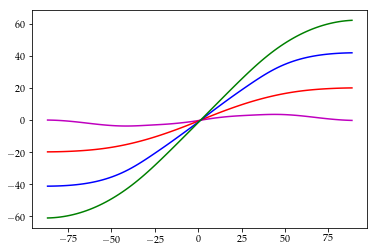

In [505]:
d=2
def D(X):
    return X[...].mean(axis=1)-X[...].mean()

for m in range(1):
    py.plot(lat[:-1], D(integrated(Net_rad2[m,...])), 'm-')
    py.plot(lat[:-1], D(integrated(SWABS[m,...])) ,'r-')
    py.plot(lat[:-1], D(integrated(SHF[m,...])) , 'b-')
    py.plot(lat[:-1], -D(integrated(olr[m,...])), 'g-')
    #py.plot(lat[:], (TE+SE+MM)[m,...].mean(axis=-1))
py.show()

In [506]:
dtheta=np.radians(lat[1]-lat[0])

def spher_div(x):
       N=1
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for m in range(12):
           div[:,m]= smooth( np.gradient((x[:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat[:])) ),N)
       return div

div_TE=np.copy(TE); div_SE=np.copy(SE); div_MM=np.copy(MM);
 
for d in range(4):
    div_TE[d,...]=spher_div(TE[d,...]*10**15)
    div_SE[d,...]=spher_div(SE[d,...]*10**15)
    div_MM[d,...]=spher_div(MM[d,...]*10**15)
div_NE=div_TE+div_SE+div_MM

In [507]:
SWABS= +SW_toa - SW_sfc
SHF  = -(shflx + lhflx + LW_sfc)
Net_rad2= SWABS + SHF + olr

dhdt=Net_rad2-(div_TE+div_SE+div_MM)
#Net_rad2= SWABS + SHF + olr -dhdt


In [508]:
def interp_rad(rad,N=1):
  D = np.zeros((4,12))
  for m in range(0,12):
       for d in range(0,4) :
            latr=lat[1:-1]
            if N==1 :
              l_range=((latr>=30) & (latr<=70)) 
              X=storm_pos_N
            else    :
              l_range=((latr>=-70) & (latr<=-30))  
              X=storm_pos_S
            interpolation_function = interp1d(latr[l_range],rad[d,l_range,m],kind='cubic')
            try :
                D[d,m]=interpolation_function(X[d,m])
            except ValueError as err:
                D[d,m]==np.nan        
  return D

In [509]:
def interad(x):
    l=np.deg2rad(lat[:,None])
    x=x*np.cos(l)
    int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*(int_x_r[:-1])#int_x[::-1][1:]+/2.0
    return avg_int_r/10**15

In [510]:
Iswabs=np.zeros((4,len(lat[1:-1]),12))
Ishf=np.copy(Iswabs); Ine=np.copy(Iswabs); Iolr=np.copy(Iswabs);Idhdt=np.copy(Iswabs)
def A(X):
    Y=(X-np.average(X, axis=0, weights=np.cos(np.radians(lat)))[None,:])
    return Y

for d in range(0,4):
    Iswabs[d,...]=interad(A(SWABS[d,...]))
    Ishf[d,...]  =interad(A(SHF[d,...]))
#    Ine[d,...]   =interad(Net_rad2[d,...]-Net_rad2[d,:,:].mean(axis=0)[None,:])
    Iolr[d,...]  =interad(A(olr[d,...]))
    Idhdt[d,...] =interad(A(dhdt[d,...]))
 
Ine=Iswabs+Ishf+Iolr#-Idhdt


In [511]:
Iswabs_clsky=np.zeros((4,len(lat[1:-1]),12))
Ishf_clsky=np.copy(Iswabs_clsky); Ine_clsky=np.copy(Iswabs_clsky); Iolr_clsky=np.copy(Iswabs_clsky);Idhdt_clsky=np.copy(Iswabs_clsky)
def A(X):
    Y=(X-np.average(X, axis=0, weights=np.cos(np.radians(lat)))[None,:])
    return Y

for d in range(0,4):
    Iswabs_clsky[d,...]=interad(A(SWABS_clsky[d,...]))
    Ishf_clsky[d,...]  =interad(A(SHF_clsky[d,...]))
#    Ine[d,...]   =interad(Net_rad2[d,...]-Net_rad2[d,:,:].mean(axis=0)[None,:])
    Iolr_clsky[d,...]  =interad(A(olr_clsky[d,...]))
    Idhdt[d,...] =interad(A(dhdt[d,...]))
 
Ine_clsky=Iswabs_clsky+Ishf_clsky+Iolr_clsky#-Idhdt


# Average Northern and Southern Hemispheres

In [512]:
TE=np.array(TE); SE=np.array(SE); MM=np.array(MM); NE=np.array(TE+MM+SE)
Iswabs=np.array(Iswabs); Ishf=np.array(Ishf); Ine=np.array(Ine); Iolr=np.array(Iolr); Idhdt=np.array(Idhdt);
Iswabs_clsky=np.array(Iswabs_clsky); Ishf_clsky=np.array(Ishf_clsky); Ine_clsky=np.array(Ine_clsky); Iolr_clsky=np.array(Iolr_clsky); Idhdt_clsky=np.array(Idhdt_clsky); 

In [513]:
sfc_temp_water=np.zeros((4,96,12)); sfc_temp_land=np.copy(sfc_temp_water); 
sfc_temp=np.copy(sfc_temp_water); temp_2m=np.copy(sfc_temp_water); 
u_10m=np.copy(sfc_temp_water); v_10m =np.copy(sfc_temp_water); 

X=[m5_nc, m10_nc, m50_nc, m100_nc]
for i in range(4) :
    sfc_temp_water[i,...], sfc_temp_land[i,...], sfc_temp[i,...], temp_2m[i,...], u_10m[i,...], v_10m[i,...]  = temp_and_wind(X[i])

lat=m5_nc['lat'][:]

In [514]:
def N_S_avg(TE, SE, MM, NE, temp, lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))
    
    avg = lambda x: (x[:,l_N,:]+flux_flag*np.roll(x[:,l_S,:][:,::-1,:], 6, axis=-1))/2.0
    
    TE1= avg(TE)
    SE1= avg(SE)
    NE1= avg(NE)
    MM1= avg(MM)
    temp= avg(temp)
    
    a= lambda x: np.append(x,x[:,:,0,None],axis=-1)
    
    return a(TE1), a(SE1), a(MM1), a(NE1), a(temp), lat[l_N]

In [515]:
TE_a   ,SE_a     , MM_a   , NE_a     ,ignore,  lat_a = N_S_avg(TE, SE, MM, NE,NE, lat)
Iswabs_a,Ishf_a  , Ine_a , Iolr_a,    Idhdt_a, latr_a = N_S_avg( Iswabs,Ishf,Ine,Iolr,Idhdt, lat[1:-1] )
Iswabs_a_clsky,Ishf_a_clsky  , Ine_a_clsky , Iolr_a_clsky,    Idhdt_a_clsky, latr_a = N_S_avg( Iswabs_clsky,Ishf_clsky,Ine_clsky,Iolr_clsky,Idhdt_clsky, lat[1:-1])
sfc_temp_water_a, sfc_temp_land_a, sfc_temp_a, temp_2_a, ignore, lat_a= N_S_avg(sfc_temp_water, sfc_temp_land, sfc_temp, temp_2m, v_10m, lat,flux_flag=1)


In [516]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div(x):
       N=1
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(4):
        for m in range(13):
           div[d,:,m]= smooth( np.gradient((x[d,:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat_a[:])) ),N)
       return div


div_TE_a = spher_div(TE_a*10**15)
div_SE_a = spher_div(SE_a*10**15)
div_MM_a = spher_div(MM_a*10**15)
div_NE_a = div_TE_a+div_SE_a+div_MM_a

In [517]:
#lat=div[0]['latn']

from scipy.interpolate import interp1d

def find_zero(div):
  zero_loc = np.zeros((4,13))
  for d in range(0,4):
      for m in range(0,13):
            l_range=((lat_a>=30) & (lat_a<=60))            
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

storm_pos=find_zero(div_TE_a)

In [518]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_max(flux,lat):
  D = np.zeros((4,13))
  for d in range(0,4):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=storm_pos
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X[d,m])
        except ValueError as err:
            D[d,m]==np.nan        
  return D

Intensity_te=inerp_at_max(TE_a,lat_a)
Intensity_se=inerp_at_max(SE_a,lat_a)
Intensity_mm=inerp_at_max(MM_a,lat_a)
Intensity_ne=inerp_at_max(NE_a,lat_a)


I_SWAB =inerp_at_max(Iswabs_a,latr_a)
I_SHF  =inerp_at_max(Ishf_a,latr_a)
I_NE   =inerp_at_max(Ine_a,latr_a)
I_OLR  =inerp_at_max(Iolr_a,latr_a)
I_dhdt =inerp_at_max(Idhdt_a,latr_a)

I_SWAB_clsky =inerp_at_max(Iswabs_a_clsky,latr_a)
I_SHF_clsky  =inerp_at_max(Ishf_a_clsky,latr_a)
I_NE_clsky   =inerp_at_max(Ine_a_clsky,latr_a)
I_OLR_clsky  =inerp_at_max(Iolr_a_clsky,latr_a)
I_dhdt_clsky =inerp_at_max(Idhdt_a_clsky,latr_a)

## Shift decompose

In [519]:
def calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=1):
    
    se=np.array(div_SE_a); te=np.array(div_TE_a); mm=np.array(div_MM_a); ne=np.array(div_NE_a)
    
    def diff(x):
        return x[:,:,1:]-x[:,:,:-1] 
    base_pos=te[...,:-1]
    
    if month_to_month==0 :
      def diff(x):
         return x[:,:,1:]-x[...,1:,None].mean(axis=2)    
      base_pos=te[...,1:,None].mean(axis=2)
        
    TE_change=base_pos+diff(te)
    NE_change=base_pos+diff(ne)
    SE_change=base_pos-diff(se)
    MM_change=base_pos-diff(mm)
    
    a = lambda x: np.append(x[:,:,-1,None],x,axis=-1)
    
    return a(SE_change), a(MM_change), a(TE_change), a(NE_change)

SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=1)

In [520]:
def find_zero(div,lower_limit=30,specific_month=-1):
  depths=div.shape[0];
  months=div.shape[-1];
  zero_loc = np.zeros((depths,months))
  for d in range(0,depths):
      for m in range(0,months):
            l_range=((lat_a>=30) & (lat_a<=65))   
            if (d<2):
                l_range=((lat_a>=35) & (lat_a<=65))   
            if m==specific_month:
                l_range=((lat_a>=lower_limit) & (lat_a<=60))
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

In [521]:
def threshold(I,value, pos1, pos2, pos3, pos4):
      for d in range(4):  
        for m in range(13):
            if (np.abs(I[d,m])<value) :
                #N[d,m]=np.nan
                pos1[d,m]=np.nan
                pos2[d,m]=np.nan
                pos3[d,m]=np.nana
                pos4[d,m]=np.nan                
      return pos1, pos2, pos3, pos4
zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, 1.0, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))

In [522]:
def plot_flux(d,threshold_value) :
    
    n=d+1
    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))
    pos=zero_div_TE
    
    if d==0:depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100

    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def add(y):
       y1 = y#np.append(y,y[:,0,np.newaxis],axis=1)
       return y1    
    
    def a(y):
       y1 = y#np.append(y,y[0])
       return y1 
    
    v = np.arange(-12.0, 13.0, threshold_value)
    latns=lat

    py.subplot(220+n)
    b = py.contourf(range(13),lat_a,add(TE_a[d,...]), v, cmap=BuRd); 
    # py.colorbar()
    c=py.contour(range(13),lat_a, add(TE_a[d,...]), v, colors='k',linewidths=1.0);
    
    py.plot(range(13), (pos[d,:]), 'ro-')
    #py.plot(range(13), (Intensity_te[d,:]*5), 'bo-')
    
    py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=40, fontsize=15)
    
    py.xticks(range(13), (mticks),fontsize=15)
    py.yticks(range(-0,81,20),fontsize=15)
    py.tick_params(labelsize=18,size=4,width=2)
    py.title(str(depth)+' m',fontsize=30)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
    py.ylim(0,60)
#     py.savefig(fig_dest+title+'_flux.pdf')
    #print fig_dest+title+'_flux.pdf'
    #py.show()

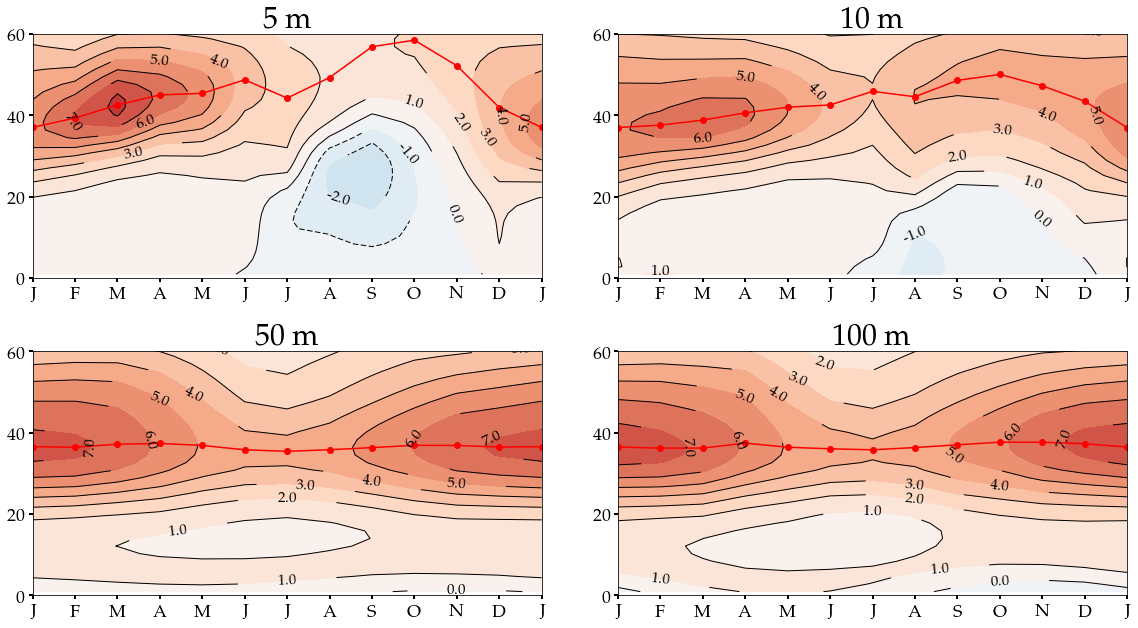

In [523]:
fig=py.figure(figsize=(20, 10))
for d in range(4):
    plot_flux(d,1.0)

In [524]:
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

def plot_monthly_shift(d,l,month_to_month=1,threshold_value=+1) :
        
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
            
    I=Intensity_te
    
    n=d+1    
#     month_to_month=1
#     threshold_value=0
    SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month)
    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))
    
    if ((d==0) & (month_to_month==0)):
        zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change,40,5), find_zero(NE_change,35,0))
    
    m=range(0,13)
    #title="Storm track shift decomposition \n (Method 2)"
    fig=py.figure(figsize=(15, 9))
    
    
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    base_pos=zero_div_TE[d,:-1]
    def add_month_to_end(y1) :
        y=np.append(y1[-1],y1)
        return y
        
    if month_to_month==0:
        s=TE_change[d,:,1:].mean(axis=-1)[None,:,None]
        base_pos=find_zero(s)
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        #base_pos=44 #np.nanmean(zero_div_TE[d,:-1])
        print base_pos
        
    TE_obs_pos         = add_month_to_end(zero_div_TE[d,1:]-base_pos)
    SE_pos             = add_month_to_end(zero_div_SE[d,1:]-base_pos)
    MM_pos             = add_month_to_end(zero_div_MM[d,1:]-base_pos)
    NE_pos             = add_month_to_end(zero_div_NE[d,1:]-base_pos)
    TE_calc_pos        = SE_pos+MM_pos+NE_pos
    nonlinear_error= TE_obs_pos-TE_calc_pos
        
#     py.subplot(220+n)
    
    fig=py.plot(TE_obs_pos,'r.-',label=r'$\Delta\phi_{ ({obs})}$',linewidth=3.5,markersize=20)
    fig=py.plot(SE_pos,'b.-',label=r'$\Delta\phi_{{{SE}}}$',linewidth=3.5,markersize=20)
    fig=py.plot(MM_pos,'g.-',label=r'$\Delta\phi_{{{MM}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(NE_pos,'m.-',label=r'$\Delta\phi_{{{NE}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(nonlinear_error,'k.-',label=r'${error}$',linewidth=2.0,markersize=20)
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,+1*l)
    py.ylabel("deg \\ poleward", fontsize=40)

    title="shift decomposition threshold"+" "+" ("+str(depth)+"m)"
    title1="shift_decomp_threshold"+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    #py.title(title, fontsize=35)
    py.xticks(m, mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
    make_sure_path_exists("/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/")
    fig_dest1="/project2/tas1/pragallva/Spring_quarter_2018/figures/position/ISCA/"
    #py.savefig(fig_dest1+title1+'.pdf')
    py.show()

[[ 42.10028309]]


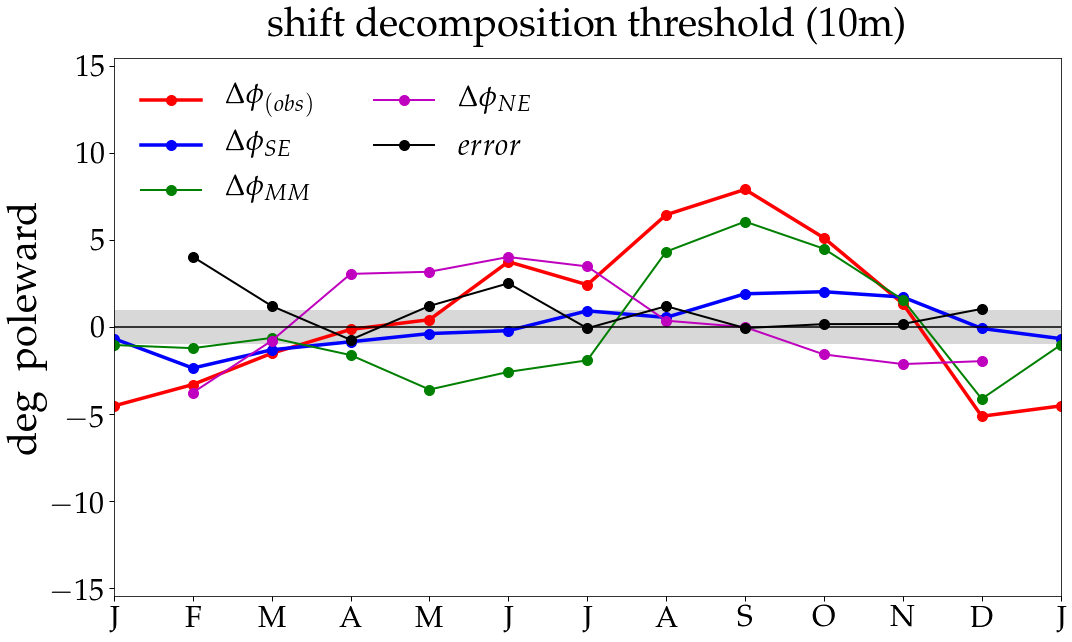

In [525]:
l=15.5
month_to_month=0; threshold_value=+1.0
plot_monthly_shift(1,l,month_to_month,threshold_value)

# Intensity decomposition

In [526]:
### radiation

def plot_intensity(d,l,month_to_month=1):
    
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        
    
    fig=py.figure(figsize=(15, 9))           
    py.plot(D(Intensity_te,d),'ro-',label=r'$\Delta I$',lw=2.5)
    py.plot(D(Intensity_ne,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)   
    py.plot(-D(Intensity_se,d),'bo-',label=r'$ - \Delta I_{SE}$',lw=2.5)
    py.plot(-D(Intensity_mm,d),'go-',label=r'$ - \Delta I_{MM}$',lw=2.5)
                                              
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title="Intensity decomposition"+" "+" ("+str(depth)+"m)"
    title1="Intensity_decomposition_"+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.5, 0.5, facecolor='0.5', alpha=0.3)
    py.legend(loc='best',fontsize=30,ncol=2,frameon=False)
    
    #py.savefig(fig_dest+title1+'.pdf')
    print fig_dest+title1+'.pdf'

    
    py.tight_layout()

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/Intensity_decomposition__100m.pdf


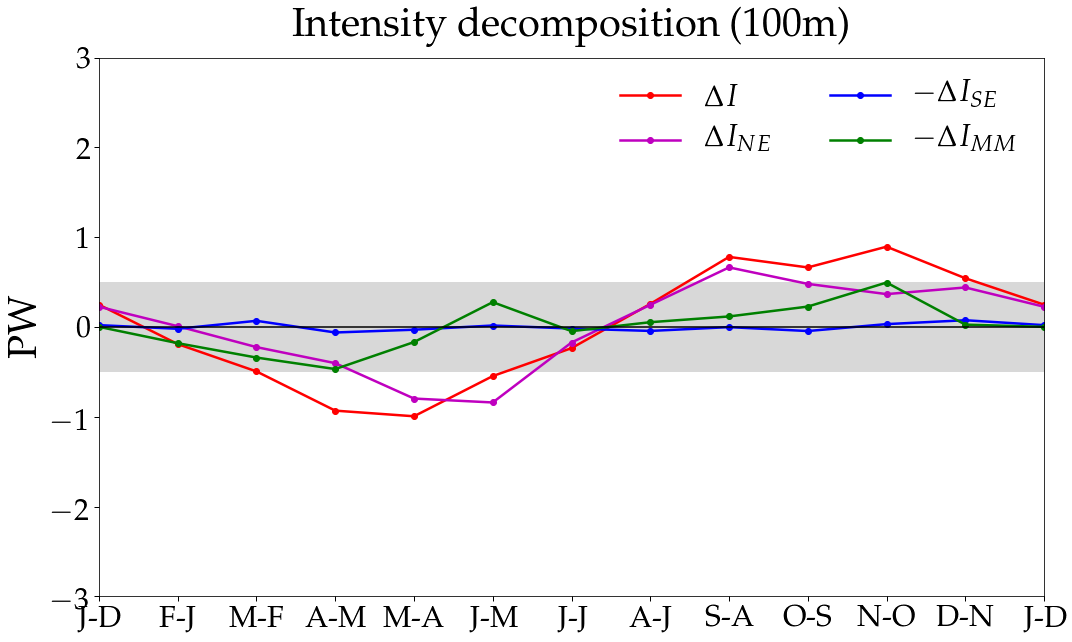

In [527]:
plot_intensity(3,3,1)

In [528]:
### radiation

def D(y,d):
    y1=np.append(y,y[:,0,np.newaxis],axis=1)
    x1=y1[d,1:]-y1[d,:-1]
    x2=np.append(x1[-1],x1)
    return x2

def plot_delta_NE(d,l,month_to_month=1):
    
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
      
    
    fig=py.figure(figsize=(15, 9))           
    py.plot(D(I_NE,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)
    py.plot(D(I_SWAB,d),'ro-',label=r'$\Delta I_{SWABS}$',lw=2.5)
    py.plot(D(I_SHF,d),'bo-',label=r'$\Delta I_{SHF}$',lw=2.5)
    py.plot(D(I_OLR,d),'go-',label=r'$ - \Delta I_{OLR}$',lw=2.5) 
        #py.plot(D(-I_dhdt_N,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
        #py.plot(D(-I_dhdt_S,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title="NE decomposition"+" "+" ("+str(depth)+"m)"
    title1="NE_decomposition_"+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.3, 0.3, facecolor='0.5', alpha=0.3)
    py.legend(fontsize=25,ncol=2,frameon=False, loc='best')
    
    #py.savefig(fig_dest+title1+'.pdf')
    print fig_dest+title1+'.pdf'

    
    py.tight_layout()

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/NE_decomposition__50m.pdf


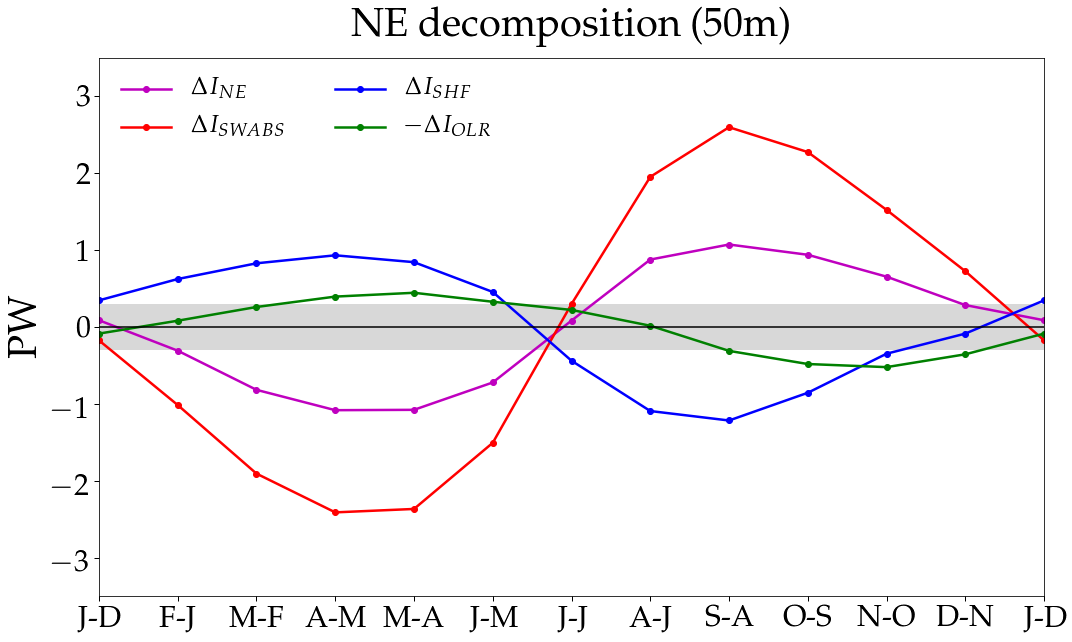

In [529]:
plot_delta_NE(2,3.5,1)

In [530]:
### radiation

def plot_delta_NE_clsky(d,l,month_to_month=1):
    
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
      
    
    fig=py.figure(figsize=(15, 9))           
    py.plot(D(I_NE_clsky,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)
    py.plot(D(I_SWAB_clsky,d),'ro-',label=r'$\Delta I_{SWABS}$',lw=2.5)
    py.plot(D(I_SHF_clsky,d),'bo-',label=r'$\Delta I_{SHF}$',lw=2.5)
    py.plot(D(I_OLR_clsky,d),'go-',label=r'$ - \Delta I_{OLR}$',lw=2.5) 
        #py.plot(D(-I_dhdt_N,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
        #py.plot(D(-I_dhdt_S,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title="NE decomposition"+" "+" ("+str(depth)+"m)"
    title1="NE_decomposition_"+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.3, 0.3, facecolor='0.5', alpha=0.3)
    py.legend(fontsize=25,ncol=2,frameon=False, loc='best')
    
    #py.savefig(fig_dest+title1+'.pdf')
    print fig_dest+title1+'.pdf'   
    py.tight_layout()

In [531]:
# d=0
# plot_delta_NE_clsky(d,10.5,0)

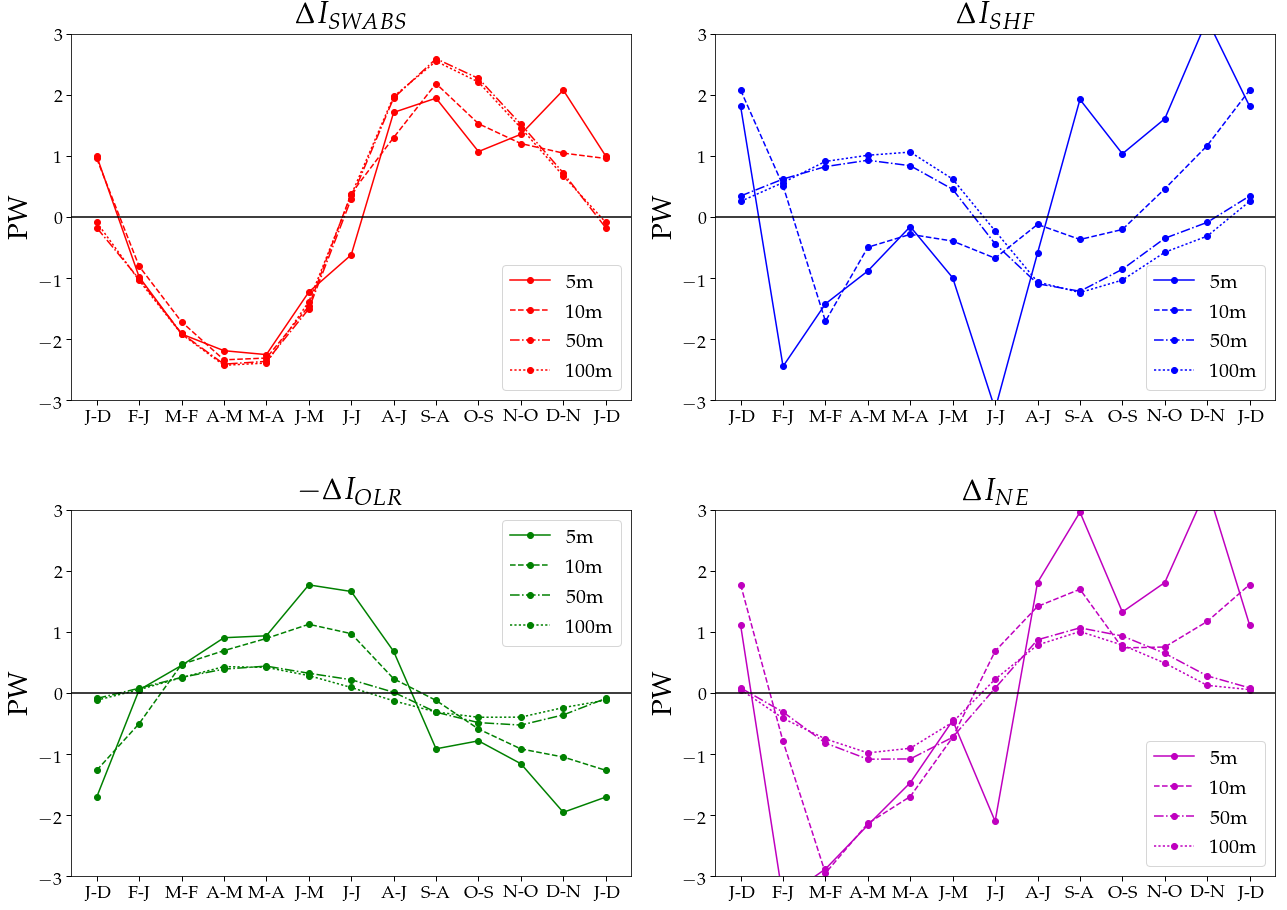

In [532]:
def compare_plot(n,X,c,T,month_to_month=1,l=3):
    py.subplot(220+n)
    d=0
    
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    def D(y):
        if month_to_month==1 :
            x1=y[1:]-y[:-1]
            x2=np.append(x1[-1],x1)
        else :
            y1=y[:]-y[:-1,None].mean(axis=0)
            x2=y1
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        
    
    py.plot(range(13),D(X[d,:]),c+'o-',label='5m')
    py.plot(range(13),D(X[d+1,:]),c+'o--',label='10m')
    py.plot(range(13),D(X[d+2,:]),c+'o-.',label='50m')
    py.plot(range(13),D(X[d+3,:]),c+'o:',label='100m')
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylabel('PW',fontsize=28)
    py.legend(loc='best',fontsize=20)
    py.axhline(0,color='k')
    py.ylim(-1*l,1*l)
    py.title(T,fontsize=30)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=18,size=5,width=1)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)


fig=py.figure(figsize=(22, 15))
compare_plot(1,I_SWAB,'r',r'$\Delta I_{SWABS}$')
compare_plot(2,I_SHF,'b',r'$\Delta I_{SHF}$')
compare_plot(3,I_OLR,'g',r'$ - \Delta I_{OLR}$')
compare_plot(4,I_NE,'m',r'$\Delta I_{NE}$')


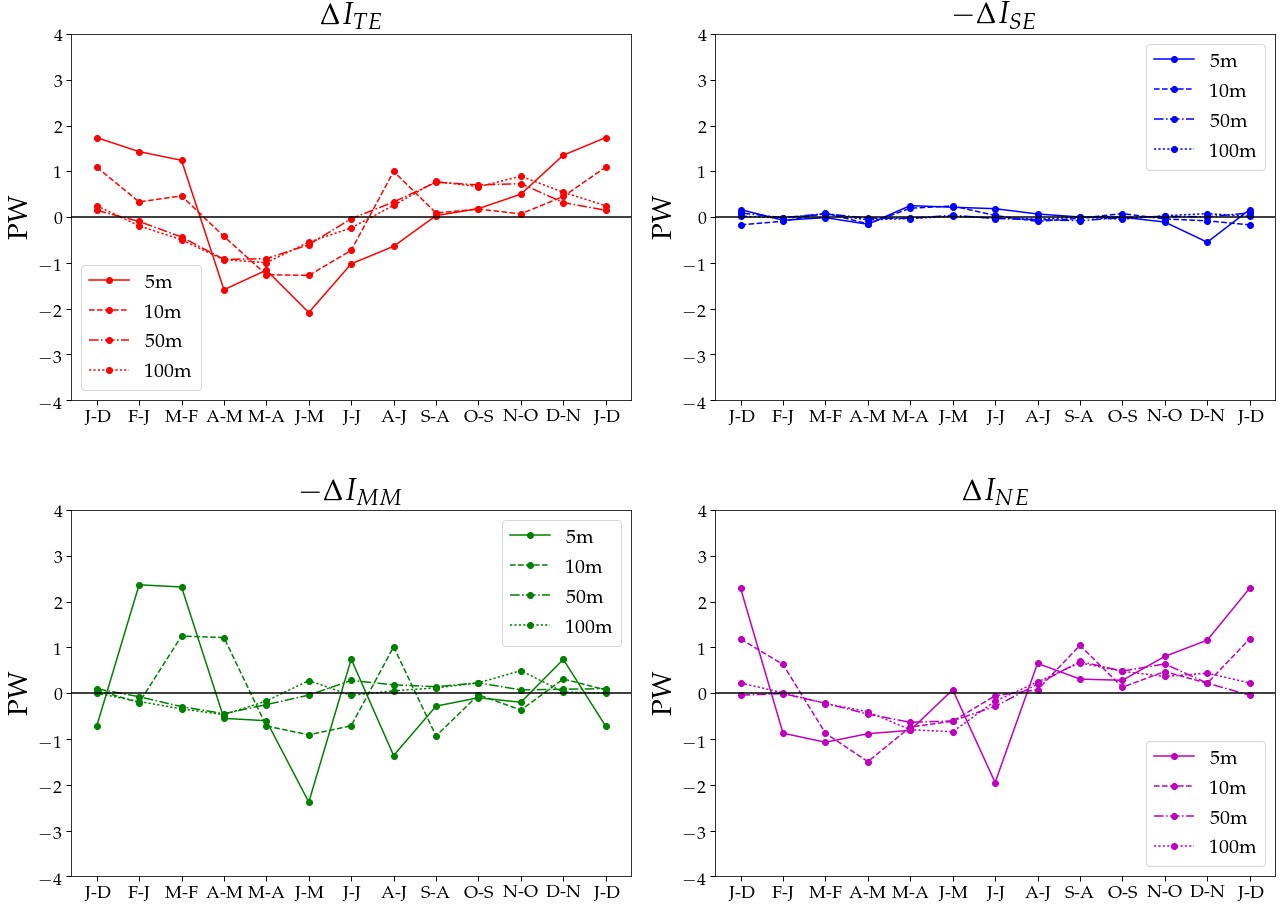

In [533]:
fig=py.figure(figsize=(22, 15))
compare_plot(1,Intensity_te,'r',r'$\Delta I_{TE}$',l=4)
compare_plot(2,-Intensity_se,'b',r'$ - \Delta I_{SE}$',l=4)
compare_plot(3,-Intensity_mm,'g',r'$ - \Delta I_{MM}$',l=4)
compare_plot(4,Intensity_ne,'m',r'$\Delta I_{NE}$',l=4)

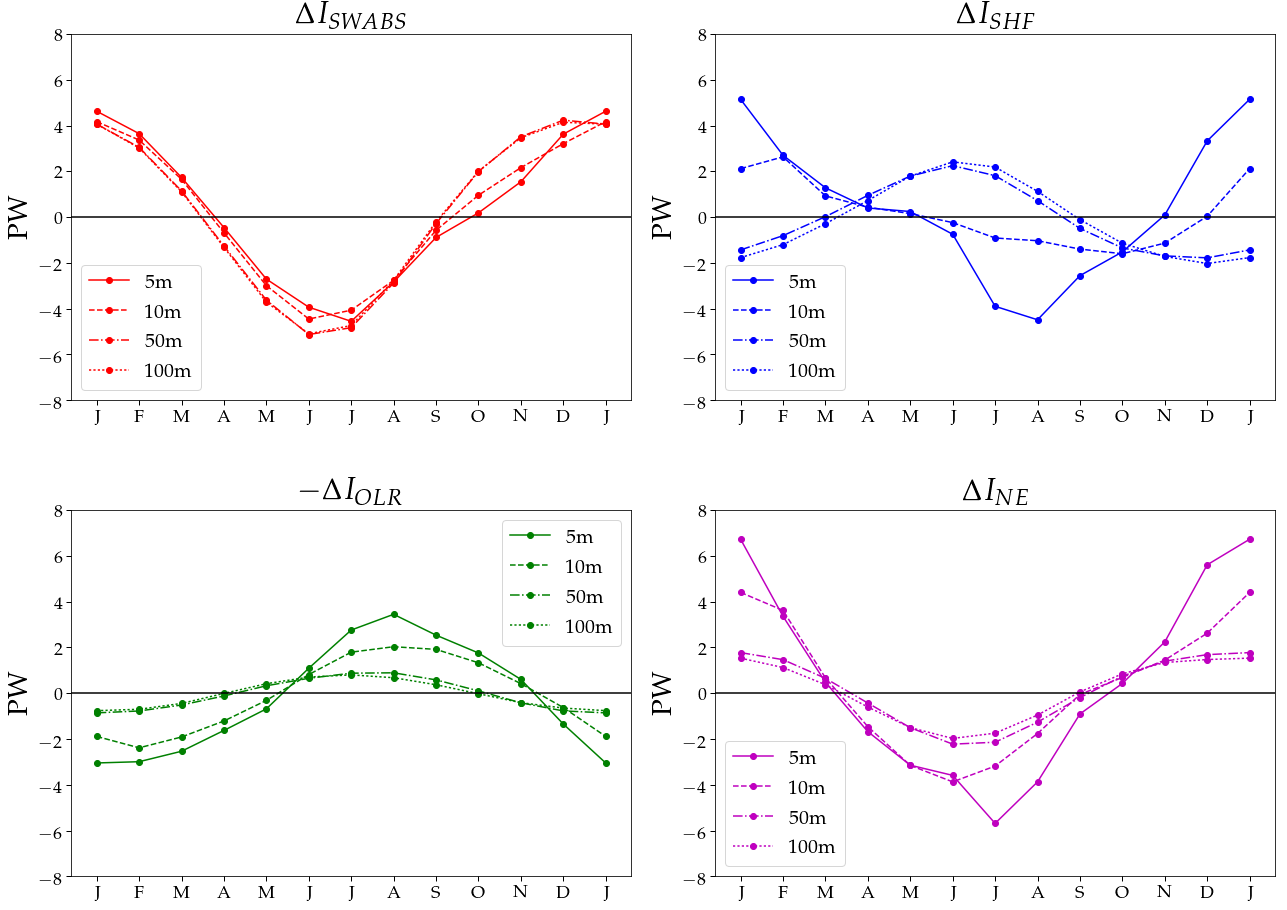

In [534]:
m_to_m=0; l=8
fig=py.figure(figsize=(22, 15))
compare_plot(1,I_SWAB,'r',r'$\Delta I_{SWABS}$',m_to_m,l)
compare_plot(2,I_SHF,'b',r'$\Delta I_{SHF}$',m_to_m,l)
compare_plot(3,I_OLR,'g',r'$ - \Delta I_{OLR}$',m_to_m,l)
compare_plot(4,I_NE,'m',r'$\Delta I_{NE}$',m_to_m,l)


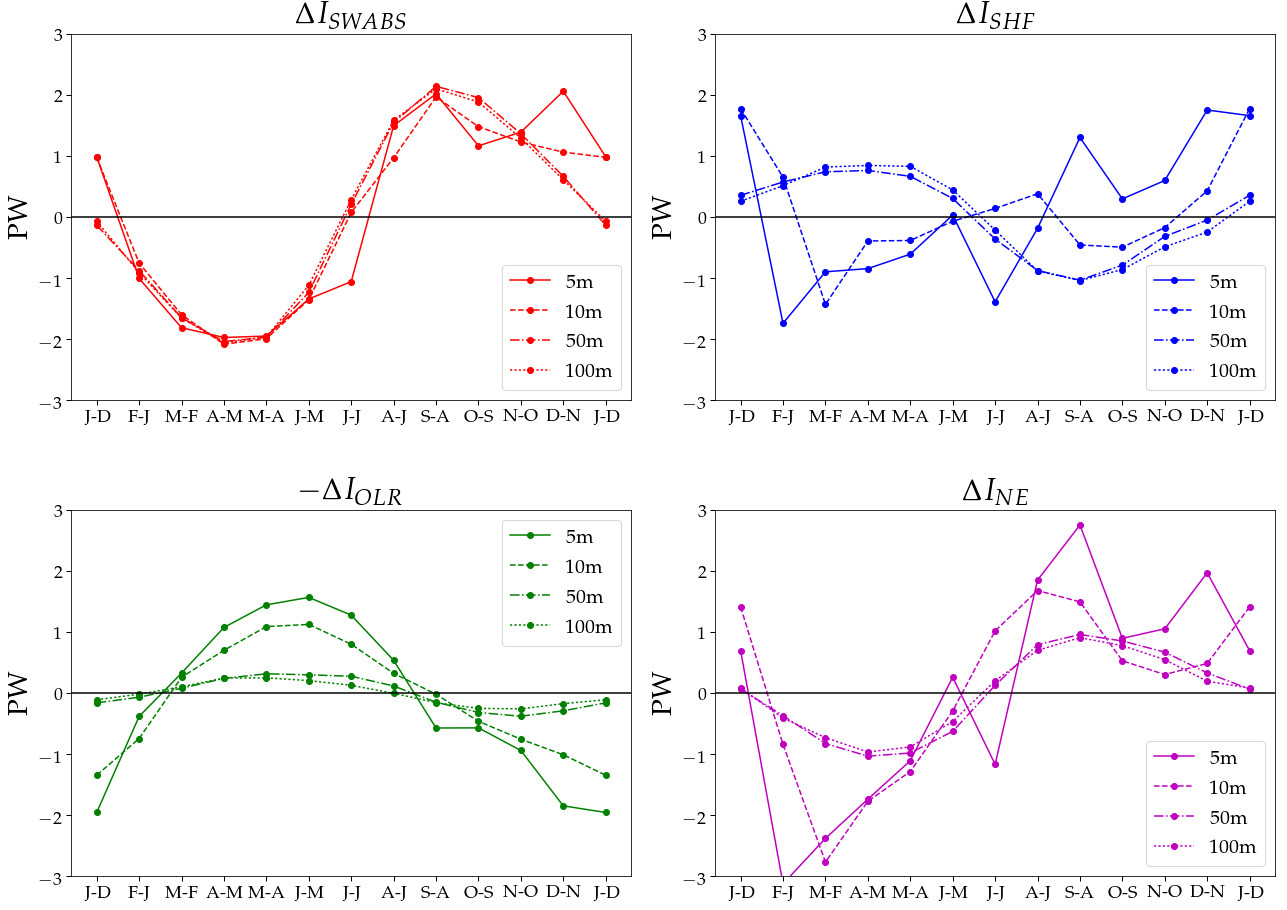

In [535]:
m_to_m=1; l=3
fig=py.figure(figsize=(22, 15))
compare_plot(1,I_SWAB_clsky,'r',r'$\Delta I_{SWABS}$',m_to_m,l)
compare_plot(2,I_SHF_clsky,'b',r'$\Delta I_{SHF}$',m_to_m,l)
compare_plot(3,I_OLR_clsky,'g',r'$ - \Delta I_{OLR}$',m_to_m,l)
compare_plot(4,I_NE_clsky,'m',r'$\Delta I_{NE}$',m_to_m,l)


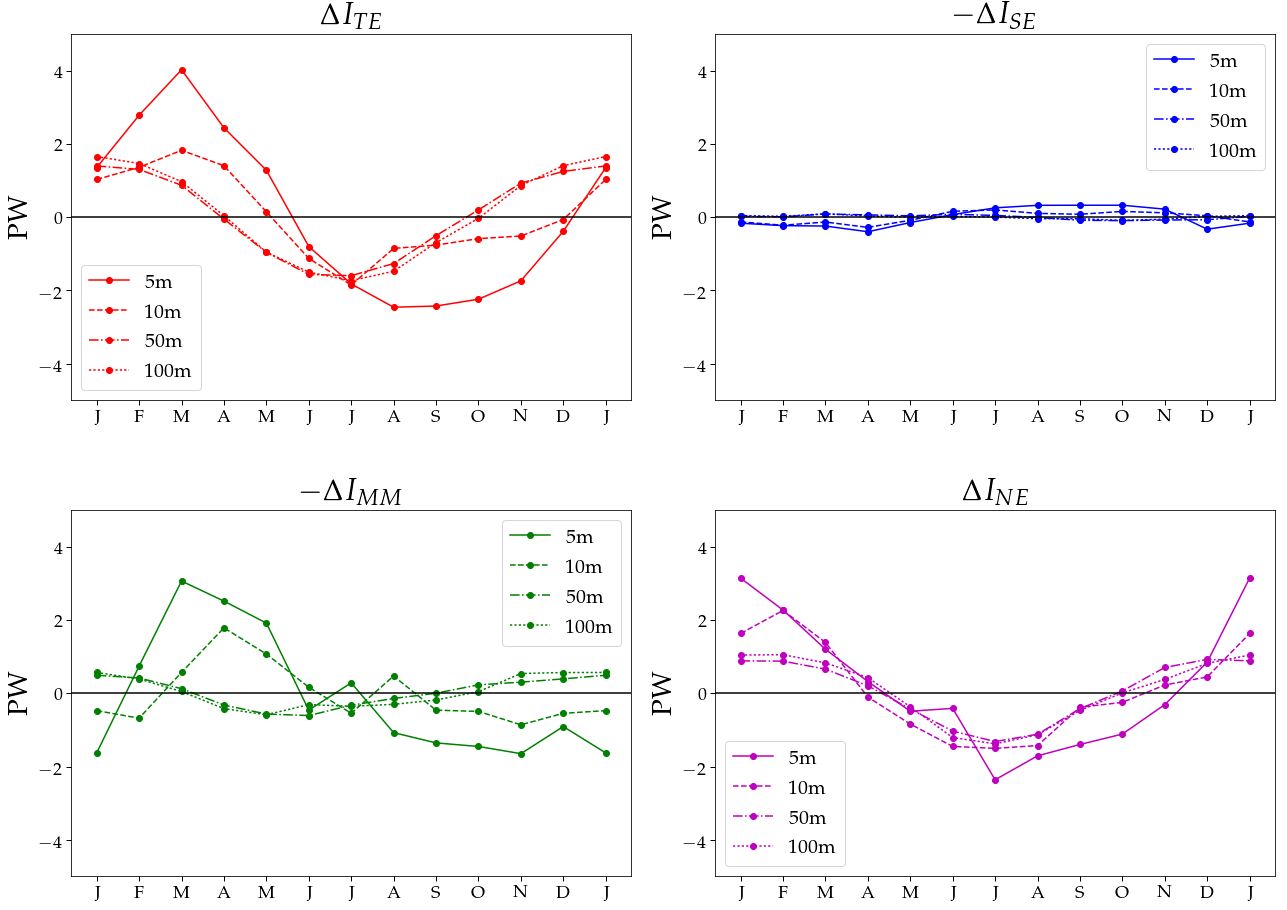

In [536]:
m_to_m=0; l=5
fig=py.figure(figsize=(22, 15))
compare_plot(1,Intensity_te,'r',r'$\Delta I_{TE}$',m_to_m,l)
compare_plot(2,-Intensity_se,'b',r'$ - \Delta I_{SE}$',m_to_m,l)
compare_plot(3,-Intensity_mm,'g',r'$ - \Delta I_{MM}$',m_to_m,l)
compare_plot(4,Intensity_ne,'m',r'$\Delta I_{NE}$',m_to_m,l)

In [537]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_40(flux,lat):
  D = np.zeros((4,13))
  for d in range(0,4):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=40
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X)
        except ValueError as err:
            D[d,m]==np.nan        
  return D


I_SWAB_at40 =inerp_at_40(Iswabs_a,latr_a)
I_SHF_at40  =inerp_at_40(Ishf_a,latr_a)
I_NE_at40   =inerp_at_40(Ine_a,latr_a)
I_OLR_at40  =inerp_at_40(Iolr_a,latr_a)
I_dhdt_at40 =inerp_at_40(Idhdt_a,latr_a)

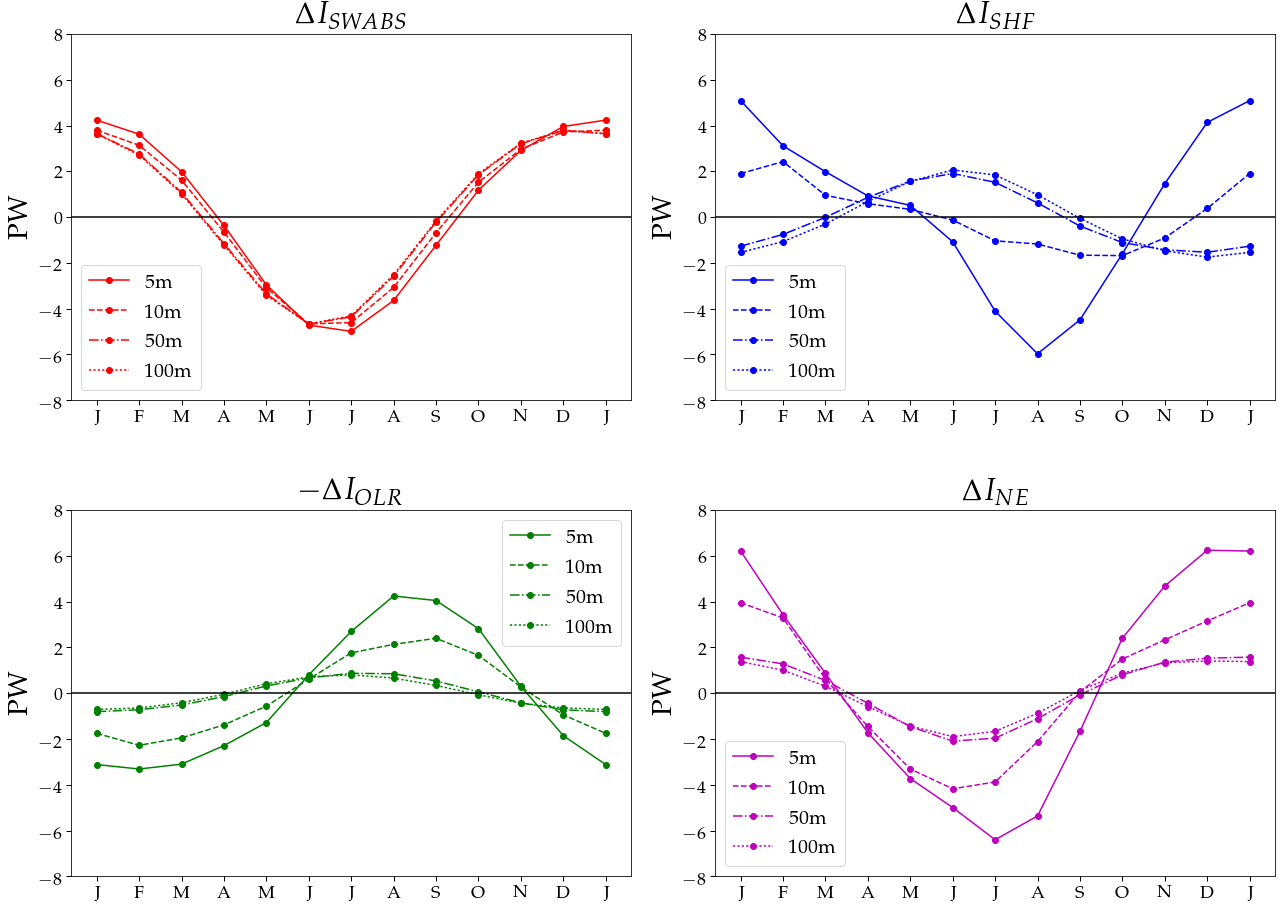

In [538]:
m_to_m=0; l=8
fig=py.figure(figsize=(22, 15))
compare_plot(1,I_SWAB_at40,'r',r'$\Delta I_{SWABS}$',m_to_m,l)
compare_plot(2,I_SHF_at40,'b',r'$\Delta I_{SHF}$',m_to_m,l)
compare_plot(3,I_OLR_at40,'g',r'$ - \Delta I_{OLR}$',m_to_m,l)
compare_plot(4,I_NE_at40,'m',r'$\Delta I_{NE}$',m_to_m,l)

# Decompose SHF to understand what dominates the phase change

In [539]:
# SWABS= +SW_toa - SW_sfc
# SHF  = -(shflx + lhflx + LW_sfc)
# Net_rad2= SWABS + SHF + olr

In [540]:
ISW_toa=np.zeros((4,len(lat[1:-1]),12))
ISW_sfc=np.copy(ISW_toa); Ishflx=np.copy(ISW_toa); Ilhflx=np.copy(ISW_toa);ILW_sfc=np.copy(ISW_toa)

def A(X):
    Y=(X-np.average(X, axis=0, weights=np.cos(np.radians(lat)))[None,:])
    return Y

for d in range(0,4):
    ISW_toa[d,...]=interad(A(SW_toa[d,...]))
    ISW_sfc[d,...]  =interad(A(SW_sfc[d,...]))
    Ishflx[d,...]  =interad(A(shflx[d,...]))
    Ilhflx[d,...] =interad(A(lhflx[d,...]))
    ILW_sfc[d,...] =interad(A(LW_sfc[d,...]))
    Idhdt[d,...]   =interad(A(LW_sfc[d,...]))
 

In [541]:
ISW_toa_a, ISW_sfc_a  , Ishflx_a , Ilhflx_a, ILW_sfc_a, latr_a = N_S_avg( ISW_toa, ISW_sfc, Ishflx, Ilhflx, ILW_sfc, lat[1:-1] )

## Check the ratio of SH/LE == Bowen ratio.

In [542]:
import numpy.ma as ma
shflx_a_mask=shflx_a#ma.masked_inside(shflx_a, -1.0e-1, +1.0e-1)
lhflx_a_mask=ma.masked_inside(lhflx_a, -9.2e-1, +9.2e-1)
old_err_state = np.seterr(divide='raise')
Bo=shflx_a_mask/lhflx_a_mask

In [543]:
I_Bo =inerp_at_max(Bo,lat_a)

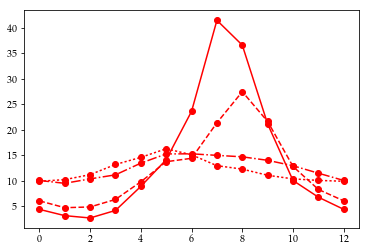

In [544]:
d=0
def D(X):
    return X
X=I_Bo**-1
c='r'
py.plot(range(13),D(X[d,:]),c+'o-',label='5m')
py.plot(range(13),D(X[d+1,:]),c+'o--',label='10m')
py.plot(range(13),D(X[d+2,:]),c+'o-.',label='50m')
py.plot(range(13),D(X[d+3,:]),c+'o:',label='100m')

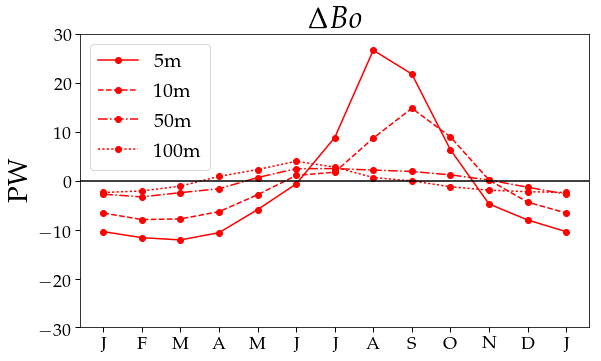

In [545]:
m_to_m=0; l=30
fig=py.figure(figsize=(20, 12))
compare_plot(1,I_Bo**-1,'r',r'$\Delta {Bo}$',m_to_m,l)

In [546]:
vv=np.arange(0.0,1.1,0.1)
print vv

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


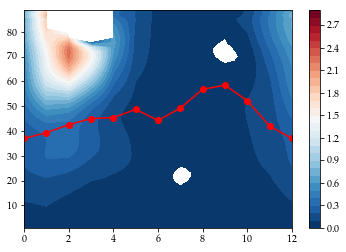

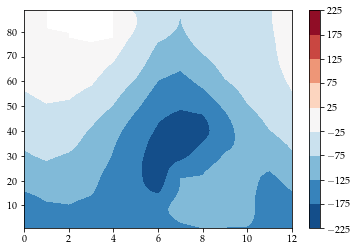

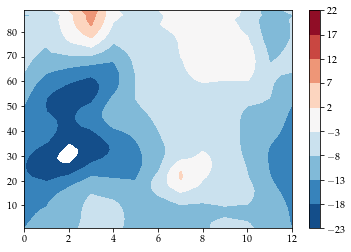

In [547]:
v=np.arange(-225,235,50)
vv=np.arange(0.0,3.0,0.1)
d=0
py.figure(0)
py.contourf(range(13), lat_a, Bo[d,...],vv,cmap=BuRd) ; py.colorbar()
py.plot(zero_div_TE[d,:],'ro-')

py.figure(1)
py.contourf(range(13), lat_a, lhflx_a_mask[d],v,cmap=BuRd) ; py.colorbar()

py.figure(2)
py.contourf(range(13), lat_a, shflx_a_mask[d],v/10,cmap=BuRd) ; py.colorbar()

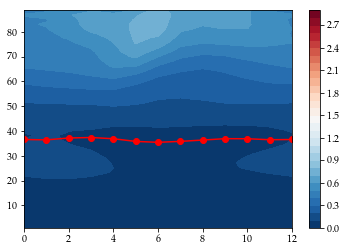

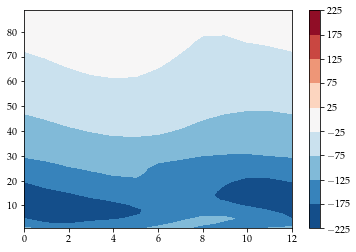

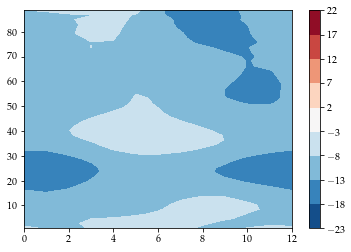

In [548]:
v=np.arange(-225,235,50)
vv=np.arange(0.0,3.0,0.1)
d=2
py.figure(0)
py.contourf(range(13), lat_a, Bo[d,...],vv,cmap=BuRd) ; py.colorbar()
py.plot(zero_div_TE[d,:],'ro-')

py.figure(1)
py.contourf(range(13), lat_a, lhflx_a_mask[d],v,cmap=BuRd) ; py.colorbar()

py.figure(2)
py.contourf(range(13), lat_a, shflx_a_mask[d],v/10,cmap=BuRd) ; py.colorbar()

In [549]:
# pick the storm track position and identify the index
I_SW_TOA =inerp_at_max(ISW_toa_a,latr_a)
I_SW_SFC =inerp_at_max(ISW_sfc_a,latr_a)
I_SHFLX  =inerp_at_max(Ishflx_a,latr_a)
I_LHFLX  =inerp_at_max(Ilhflx_a,latr_a)
I_LW_SFC =inerp_at_max(ILW_sfc_a,latr_a)

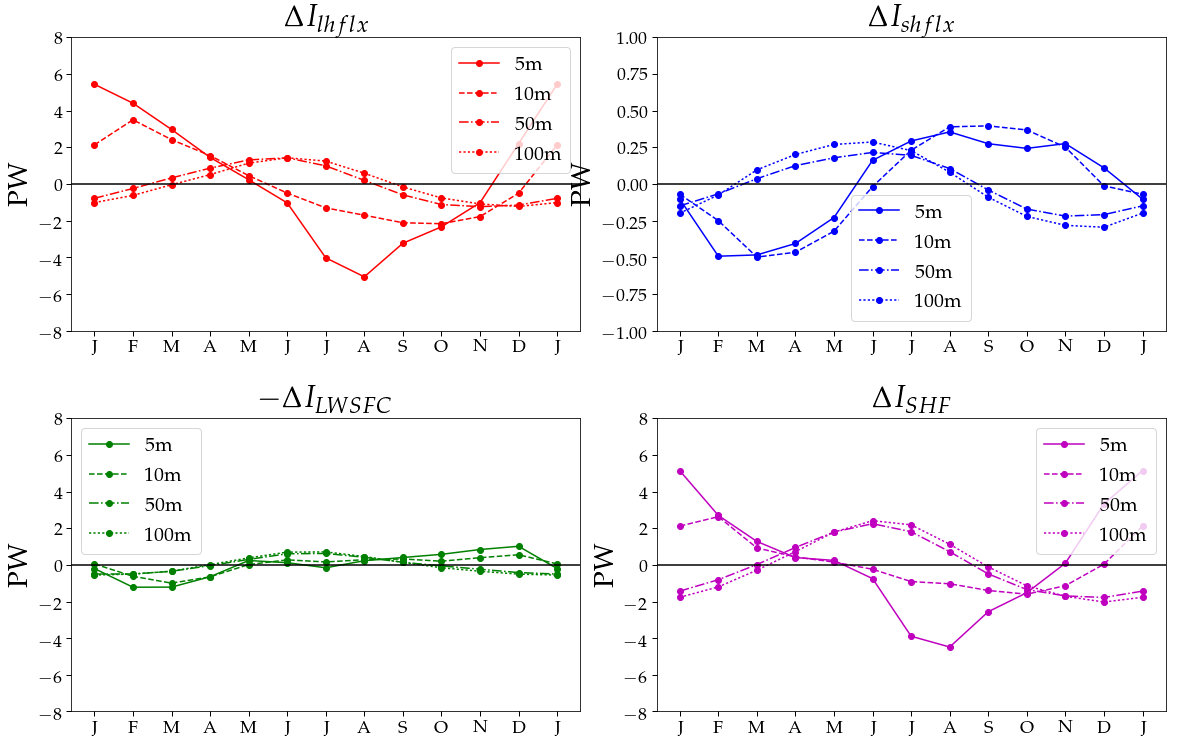

In [550]:
m_to_m=0; l=8
fig=py.figure(figsize=(20, 12))
compare_plot(1,-I_LHFLX,'r',r'$\Delta I_{lhflx}$',m_to_m,l)
compare_plot(2,-I_SHFLX,'b',r'$\Delta I_{shflx}$',m_to_m,l-7)
compare_plot(3,-I_LW_SFC,'g',r'$ - \Delta I_{LW SFC}$',m_to_m,l)
compare_plot(4,I_SHF,'m',r'$\Delta I_{SHF}$',m_to_m,l)

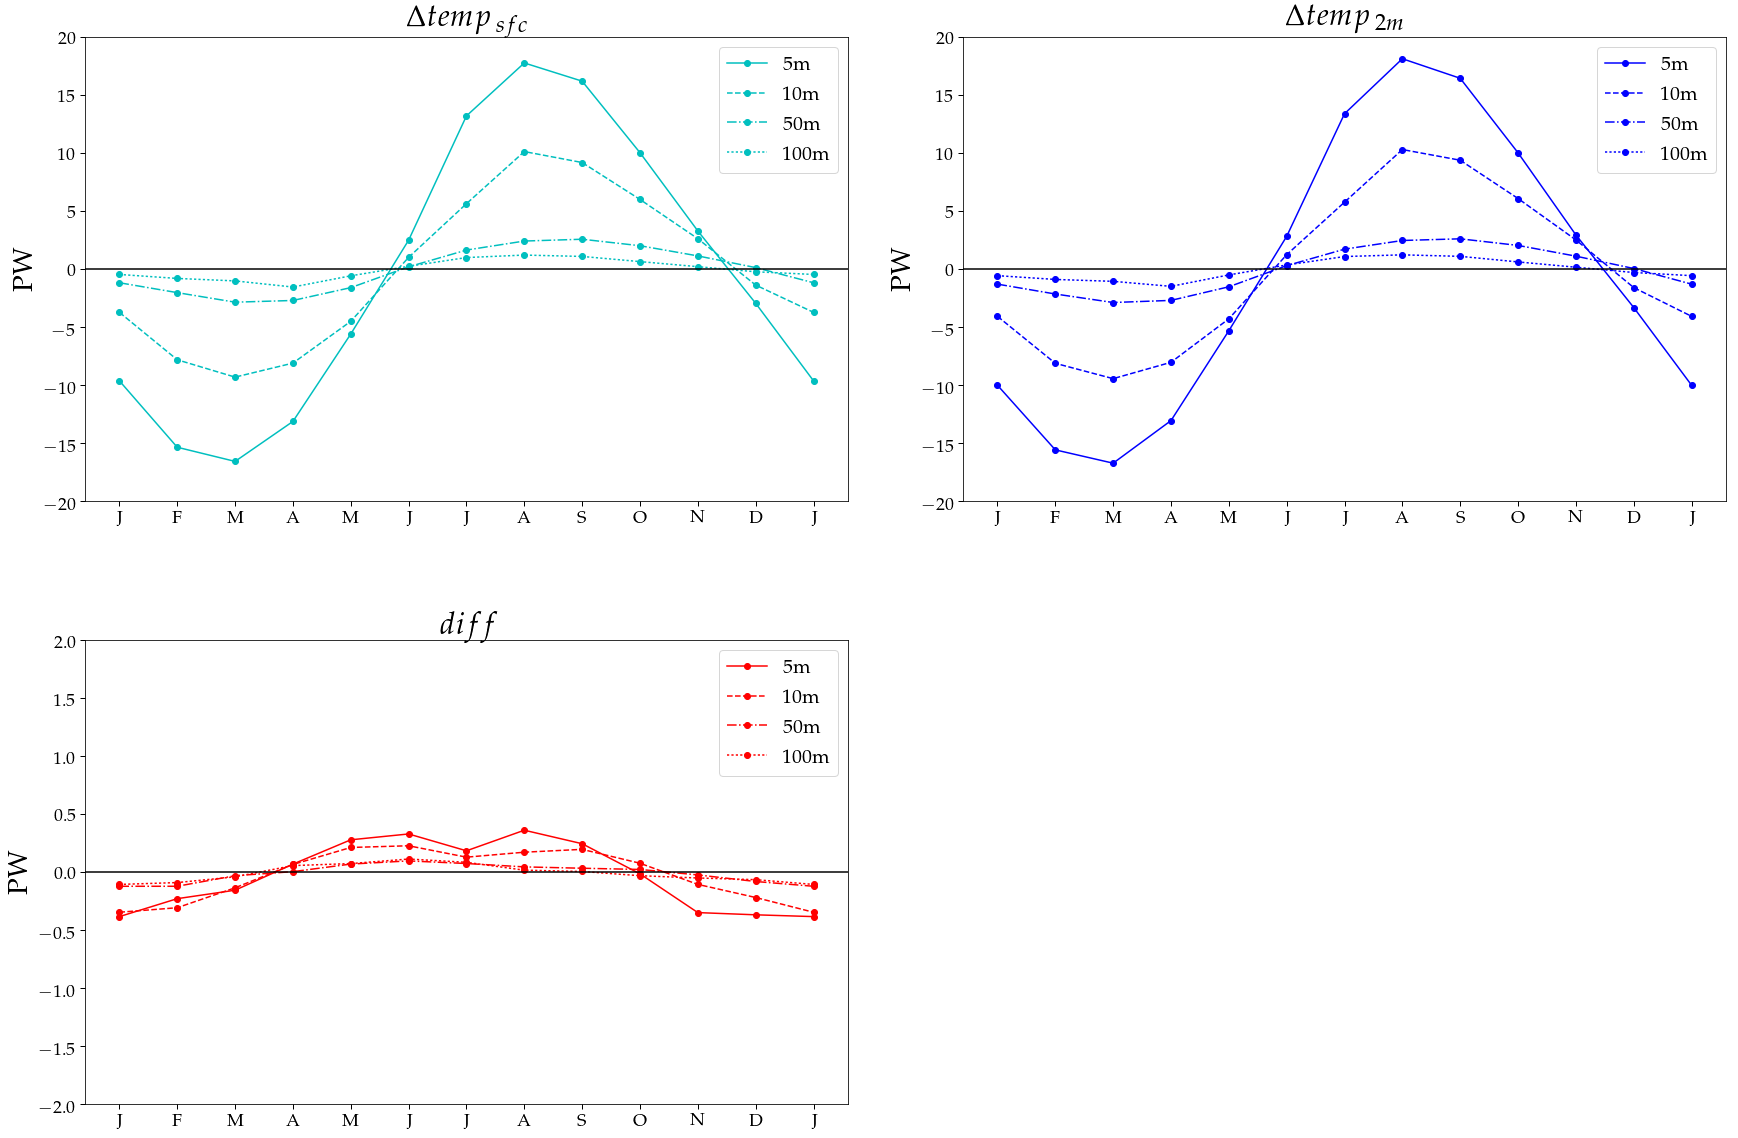

In [551]:
# SWABS= +SW_toa - SW_sfc
# SHF  = -(shflx + lhflx + LW_sfc)
# Net_rad2= SWABS + SHF + olr

I_sfc_temp =inerp_at_max(sfc_temp_a,lat_a)
I_2m_temp =inerp_at_max(temp_2_a,lat_a)
m_to_m=0; l=20
fig=py.figure(figsize=(30, 19))
compare_plot(1,I_sfc_temp,'c',r'$\Delta temp_{\:sfc}$',m_to_m,l)
compare_plot(2,I_2m_temp,'b',r'$\Delta temp_{\:2m}$',m_to_m,l)
compare_plot(3,-I_sfc_temp+I_2m_temp,'r',r'${diff}$',m_to_m,l/10)

In [552]:
u_10m.shape

(4, 96, 12)

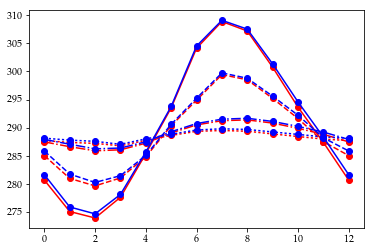

In [553]:

d=0
def D(X):
    return X
X=I_2m_temp
c='r'
py.plot(range(13),D(X[d,:]),c+'o-',label='5m')
py.plot(range(13),D(X[d+1,:]),c+'o--',label='10m')
py.plot(range(13),D(X[d+2,:]),c+'o-.',label='50m')
py.plot(range(13),D(X[d+3,:]),c+'o:',label='100m')

X=I_sfc_temp
c='b'
py.plot(range(13),D(X[d,:]),c+'o-',label='5m')
py.plot(range(13),D(X[d+1,:]),c+'o--',label='10m')
py.plot(range(13),D(X[d+2,:]),c+'o-.',label='50m')
py.plot(range(13),D(X[d+3,:]),c+'o:',label='100m')

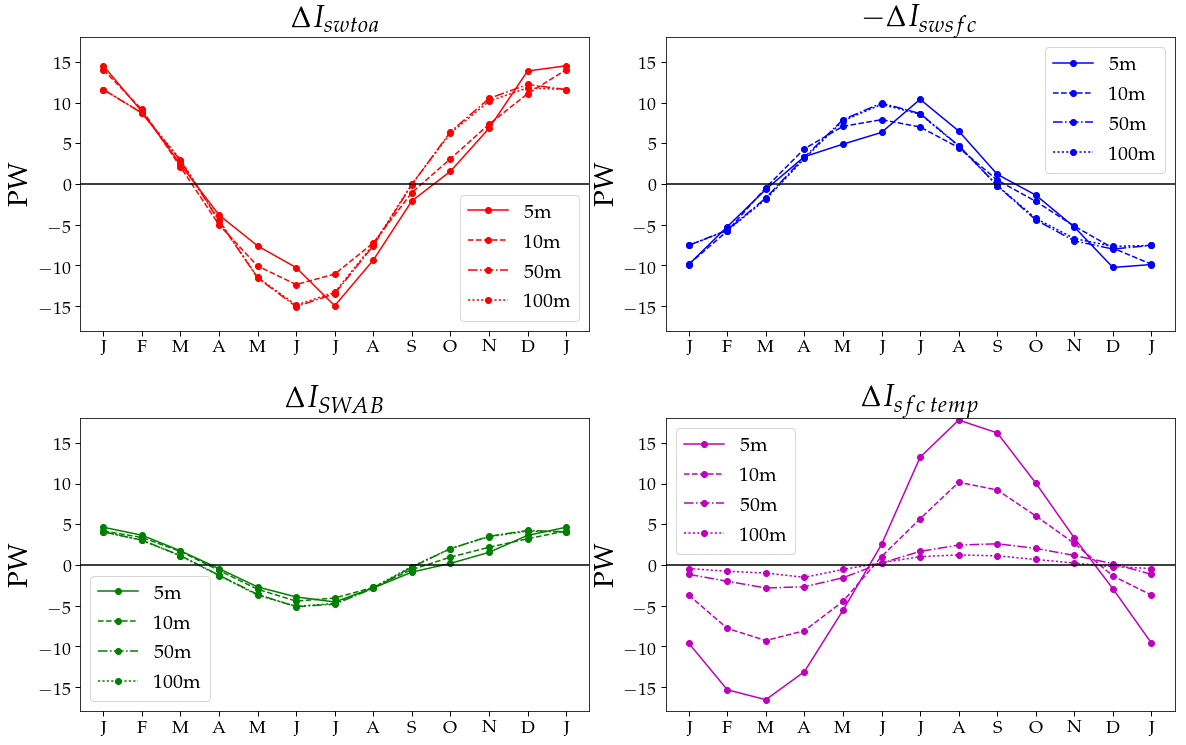

In [554]:
m_to_m=0; l=18
fig=py.figure(figsize=(20, 12))
compare_plot(1,+I_SW_TOA ,'r',r'$\Delta I_{swtoa}$',m_to_m,l)
compare_plot(2,-I_SW_SFC,'b',r'$- \Delta I_{swsfc}$',m_to_m,l)
compare_plot(3,I_SWAB,'g',r'$ \Delta I_{SWAB}$',m_to_m,l)
compare_plot(4,I_sfc_temp,'m',r'$\Delta I_{sfc\:temp}$',m_to_m,l)


# Decompose Net energy in Watts/m^2

In [555]:
# SWABS= +SW_toa - SW_sfc
# SHF  = -(shflx + lhflx + LW_sfc)
# Net_rad2= SWABS + SHF + olr

In [556]:
dhdt=SWABS + SHF + olr-(div_TE+div_SE+div_MM)
# Net_rad2= SWABS + SHF + olr -dhdt

In [557]:
SWABS_a, SHF_a  , NE_a , OLR_a, dhdt_a, lat_a = N_S_avg( SWABS,SHF, Net_rad2 ,olr, dhdt, lat, flux_flag=1)
SW_toa_a, SW_sfc_a  , shflx_a , lhflx_a, LW_sfc_a, lat_a = N_S_avg( SW_toa, SW_sfc, shflx, lhflx, LW_sfc, lat,flux_flag=1)

In [558]:
# pick the storm track position and identify the index
P_SW_TOA =inerp_at_max(SW_toa_a,lat_a)
P_SW_SFC =inerp_at_max(SW_sfc_a,lat_a)
P_SHFLX  =inerp_at_max(shflx_a,lat_a)
P_LHFLX  =inerp_at_max(lhflx_a,lat_a)
P_LW_SFC =inerp_at_max(LW_sfc_a,lat_a)

In [559]:
P_SWABS =inerp_at_max(SWABS_a,lat_a)
P_SHF =inerp_at_max(SHF_a,lat_a)
P_NE  =inerp_at_max(NE_a,lat_a)
P_OLR  =inerp_at_max(OLR_a,lat_a)
P_dhdt =inerp_at_max(dhdt_a,lat_a)

In [560]:
def compare_plot1(n,X,c,T,month_to_month=1,l=3):
    py.subplot(220+n)
    d=0
    
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    def D(y):
        if month_to_month==1 :
            x1=y[1:]-y[:-1]
            x2=np.append(x1[-1],x1)
        else :
            y1=y[:]-y[:-1,None].mean(axis=0)
            x2=y1
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        
    
    py.plot(range(13),D(X[d,:]),c+'o-',label='5m')
    py.plot(range(13),D(X[d+1,:]),c+'o--',label='10m')
    py.plot(range(13),D(X[d+2,:]),c+'o-.',label='50m')
    py.plot(range(13),D(X[d+3,:]),c+'o:',label='100m')
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylabel(r'$W/m^{2}$',fontsize=28)
    py.legend(loc='best',fontsize=20)
    py.axhline(0,color='k')
    py.ylim(-1*l,1*l)
    py.title(T,fontsize=30)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=18,size=5,width=1)
    #py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
    py.tight_layout()

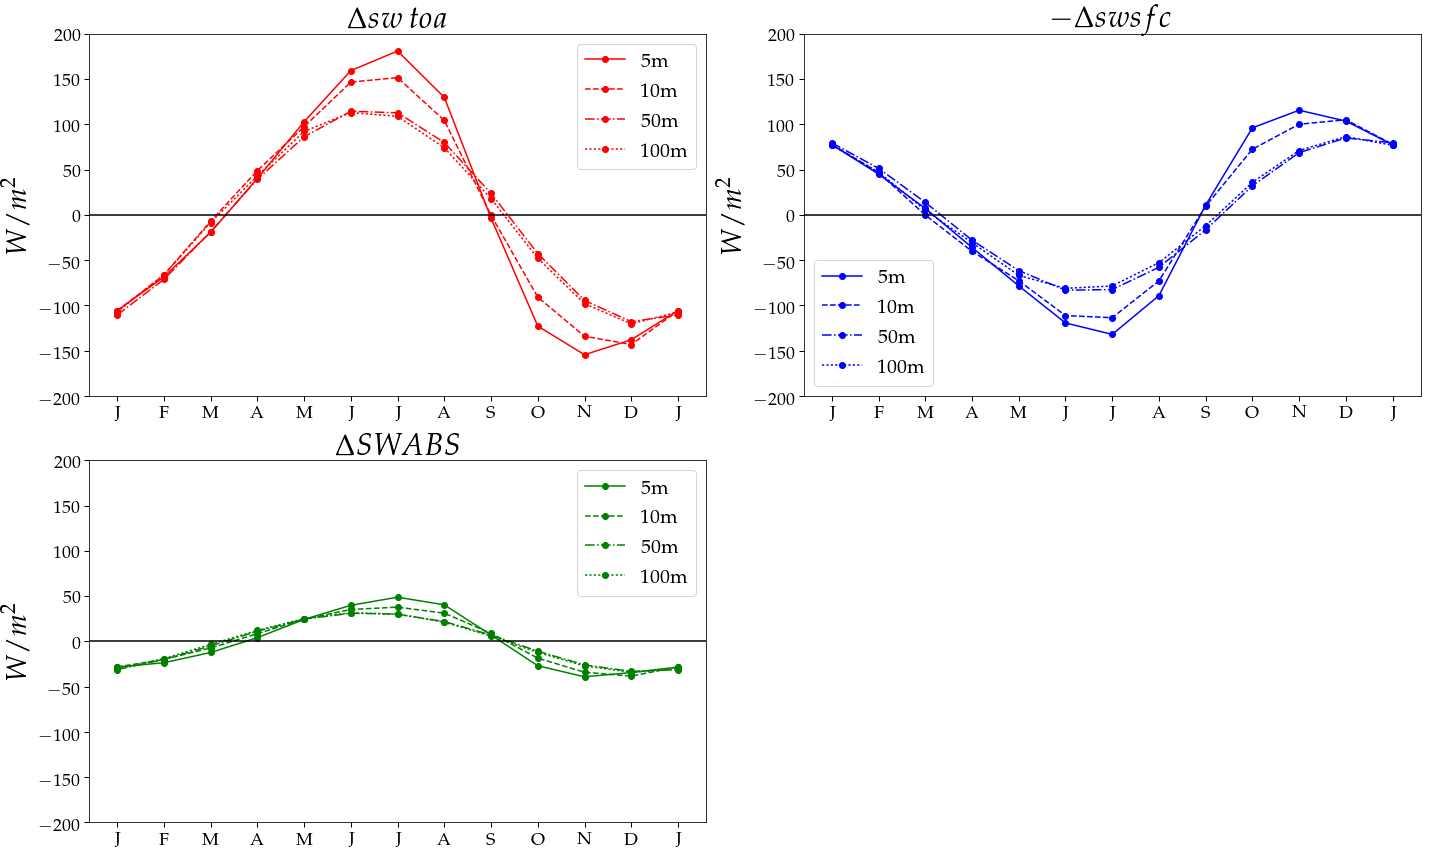

In [561]:
m_to_m=0; l=200
fig=py.figure(figsize=(20, 12))
compare_plot1(1,+P_SW_TOA ,'r',r'$\Delta {sw\:toa}$',m_to_m,l)
# compare_plot(1,I_SW_TOA*10,'y',r'$ \Delta I_{SW TOA}$',m_to_m,l)
compare_plot1(2,-P_SW_SFC,'b',r'$- \Delta {swsfc}$',m_to_m,l)
# compare_plot(2,-I_SW_SFC*10,'y',r'$ -\Delta I_{SW SFC}$',m_to_m,l)
compare_plot1(3,P_SWABS,'g',r'$ \Delta {SWABS}$',m_to_m,l)
#compare_plot(4,I_sfc_temp,'m',r'$\Delta I_{sfc\:temp}$',m_to_m,l)
# compare_plot(3,I_SWAB*10,'y',r'$ \Delta I_{SWAB}$',m_to_m,l)
#compare_plot(4,I_SHF,'m',r'$\Delta I_{SHF}$',m_to_m,l)

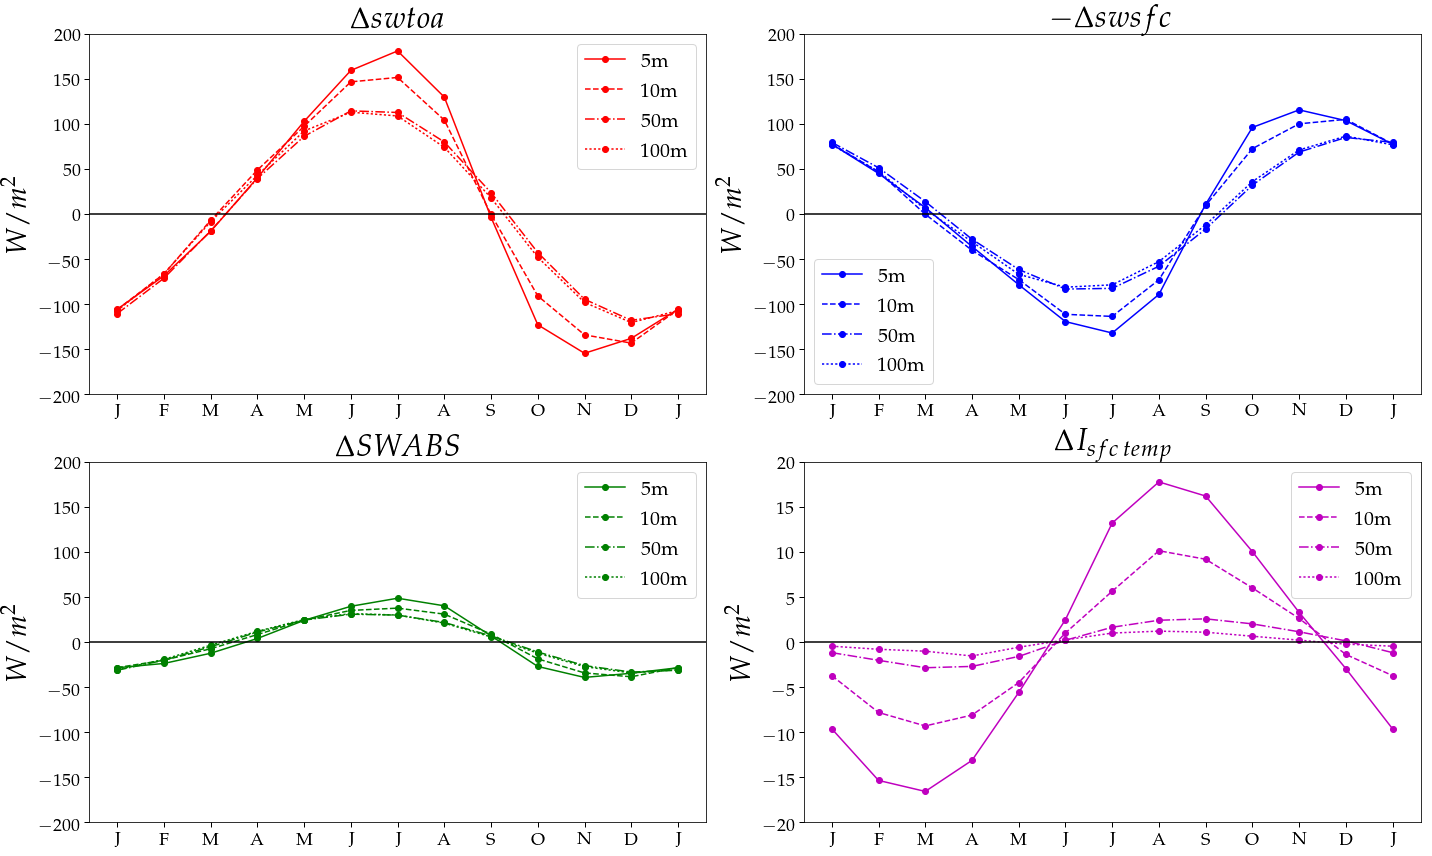

In [562]:
m_to_m=0; l=200
fig=py.figure(figsize=(20, 12))
compare_plot1(1,+P_SW_TOA ,'r',r'$\Delta {swtoa}$',m_to_m,l)
compare_plot1(2,-P_SW_SFC,'b',r'$- \Delta {swsfc}$',m_to_m,l)
compare_plot1(3,P_SWABS,'g',r'$ \Delta {SWABS}$',m_to_m,l)
compare_plot1(4,I_sfc_temp,'m',r'$\Delta I_{sfc\:temp}$',m_to_m,l/10)
#compare_plot(4,I_SHF,'m',r'$\Delta I_{SHF}$',m_to_m,l)

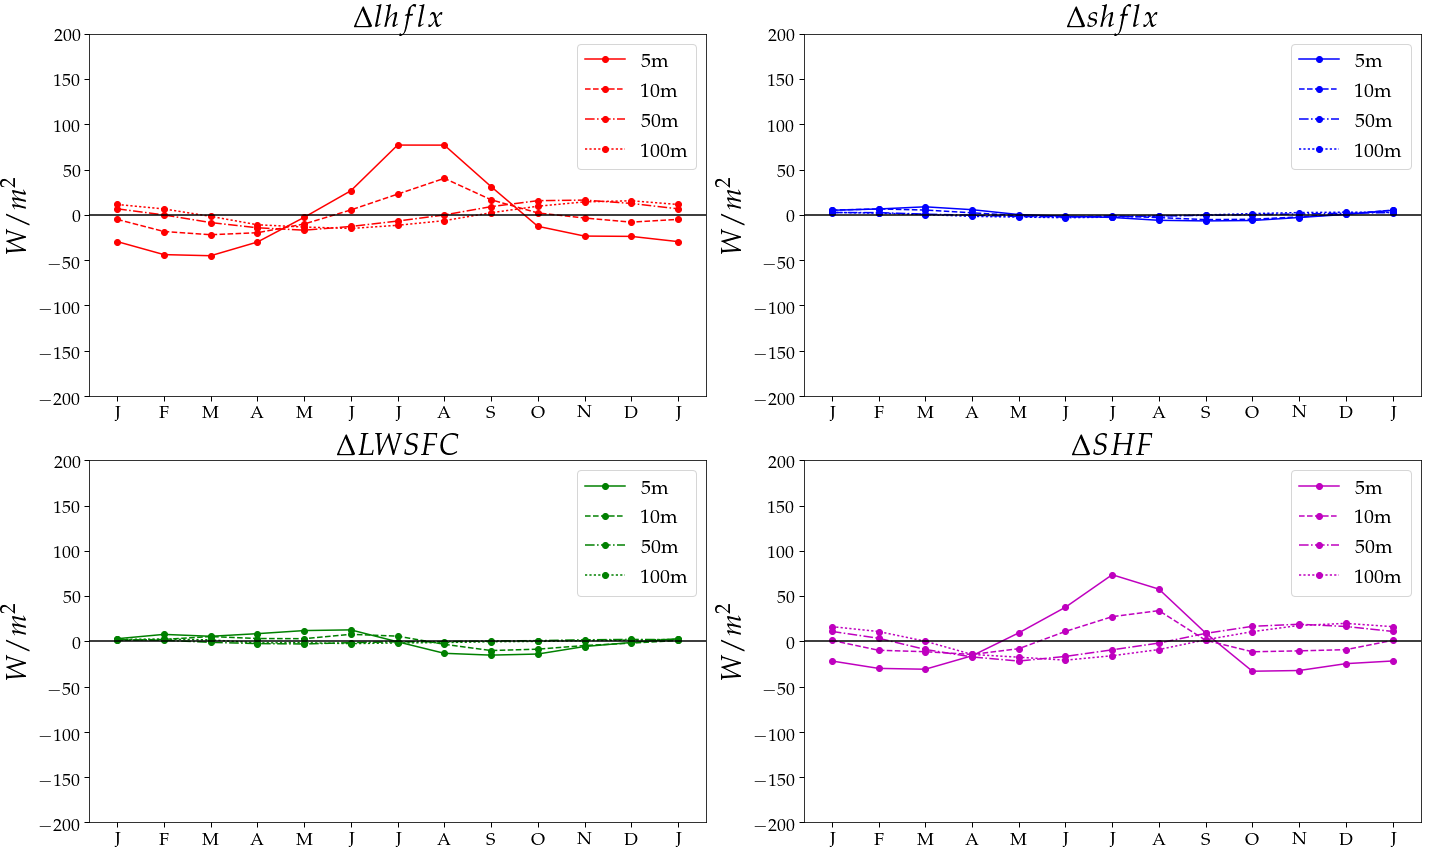

In [563]:
m_to_m=0; l=200
fig=py.figure(figsize=(20, 12))
compare_plot1(1,-P_LHFLX,'r',r' $\Delta {lhflx}$',m_to_m,l)
compare_plot1(2,-P_SHFLX,'b',r' $\Delta {shflx}$',m_to_m,l)
compare_plot1(3,-P_LW_SFC,'g',r'$  \Delta {LW SFC}$',m_to_m,l)
compare_plot1(4,P_SHF,'m',r'$\Delta {SHF}$',m_to_m,l)

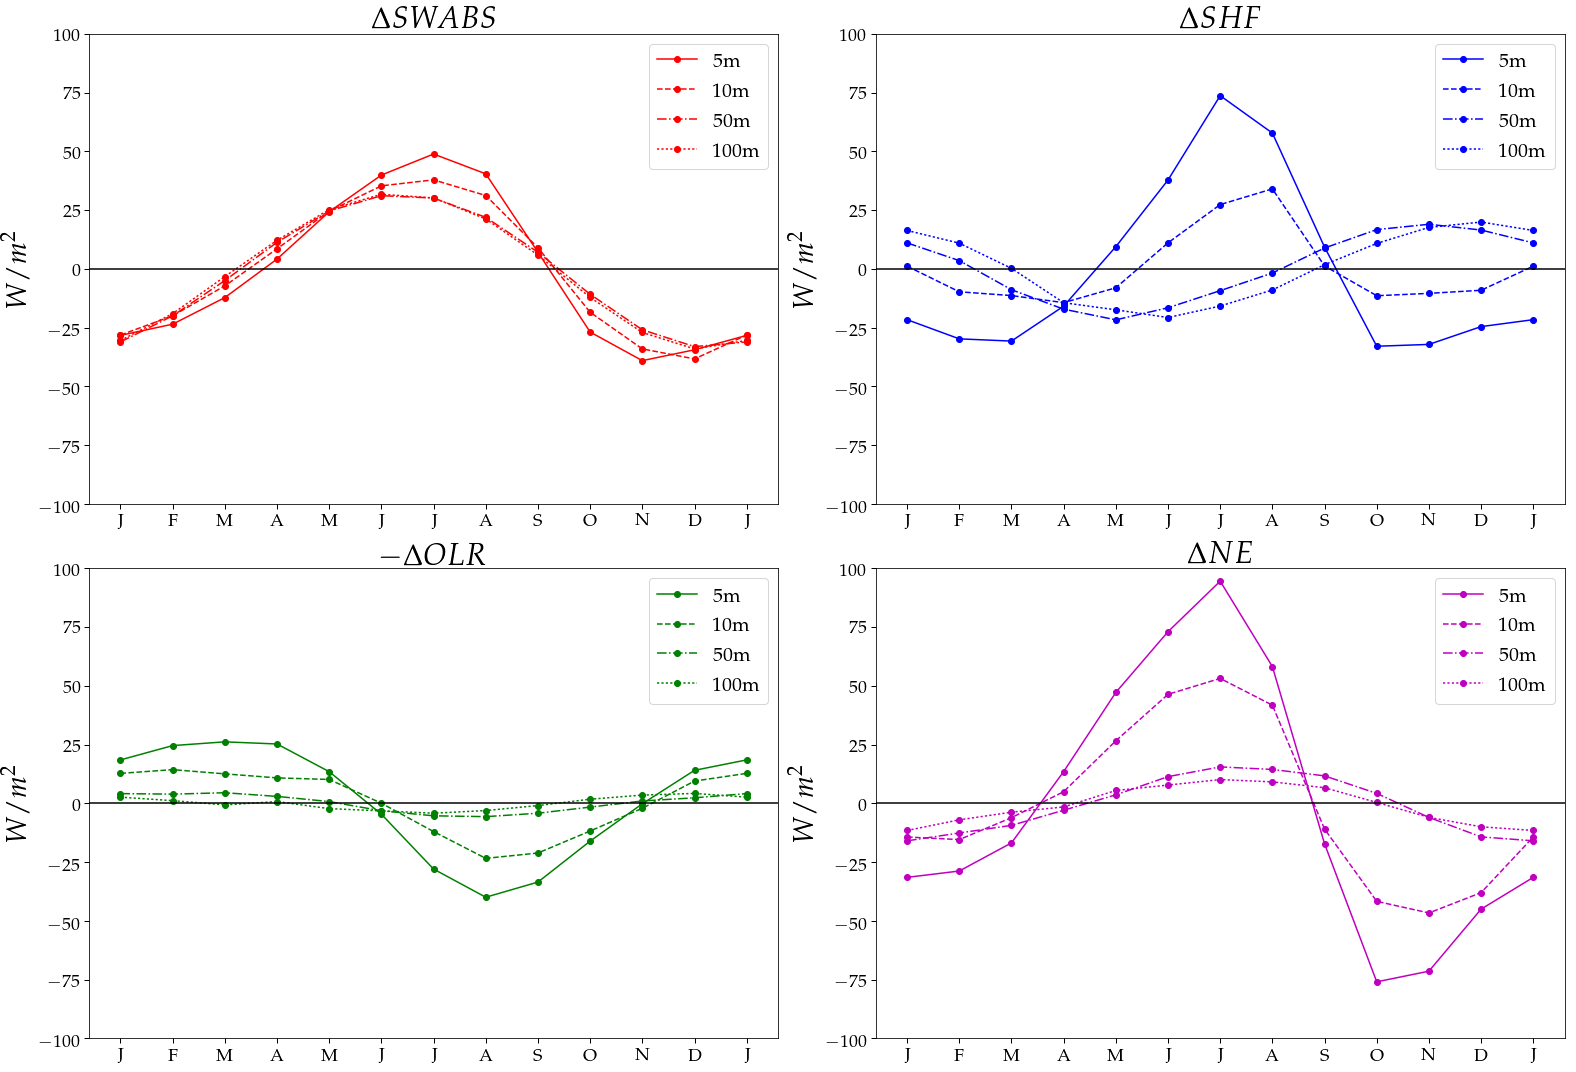

In [564]:
m_to_m=0; l=100
fig=py.figure(figsize=(22, 15))
compare_plot1(1,P_SWABS,'r',r'$\Delta {SWABS}$',m_to_m,l)
compare_plot1(2,P_SHF,'b',r'$\Delta {SHF}$',m_to_m,l)
compare_plot1(3,P_OLR,'g',r'$ - \Delta {OLR}$',m_to_m,l)
compare_plot1(4,P_NE,'m',r'$\Delta {NE}$',m_to_m,l)

In [565]:
def inerp_at_mean(flux,lat):
  D = np.zeros((4,13))
  for d in range(0,4):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=zero_div_TE[d,:-1].mean()
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X)
        except ValueError as err:
            D[d,m]==np.nan        
  return D

In [566]:
P_div_TE =inerp_at_mean(div_TE_a,lat_a)
P_div_SE =inerp_at_mean(div_SE_a,lat_a)
P_div_NE =inerp_at_mean(div_NE_a,lat_a)
P_div_MM =inerp_at_mean(div_MM_a,lat_a)

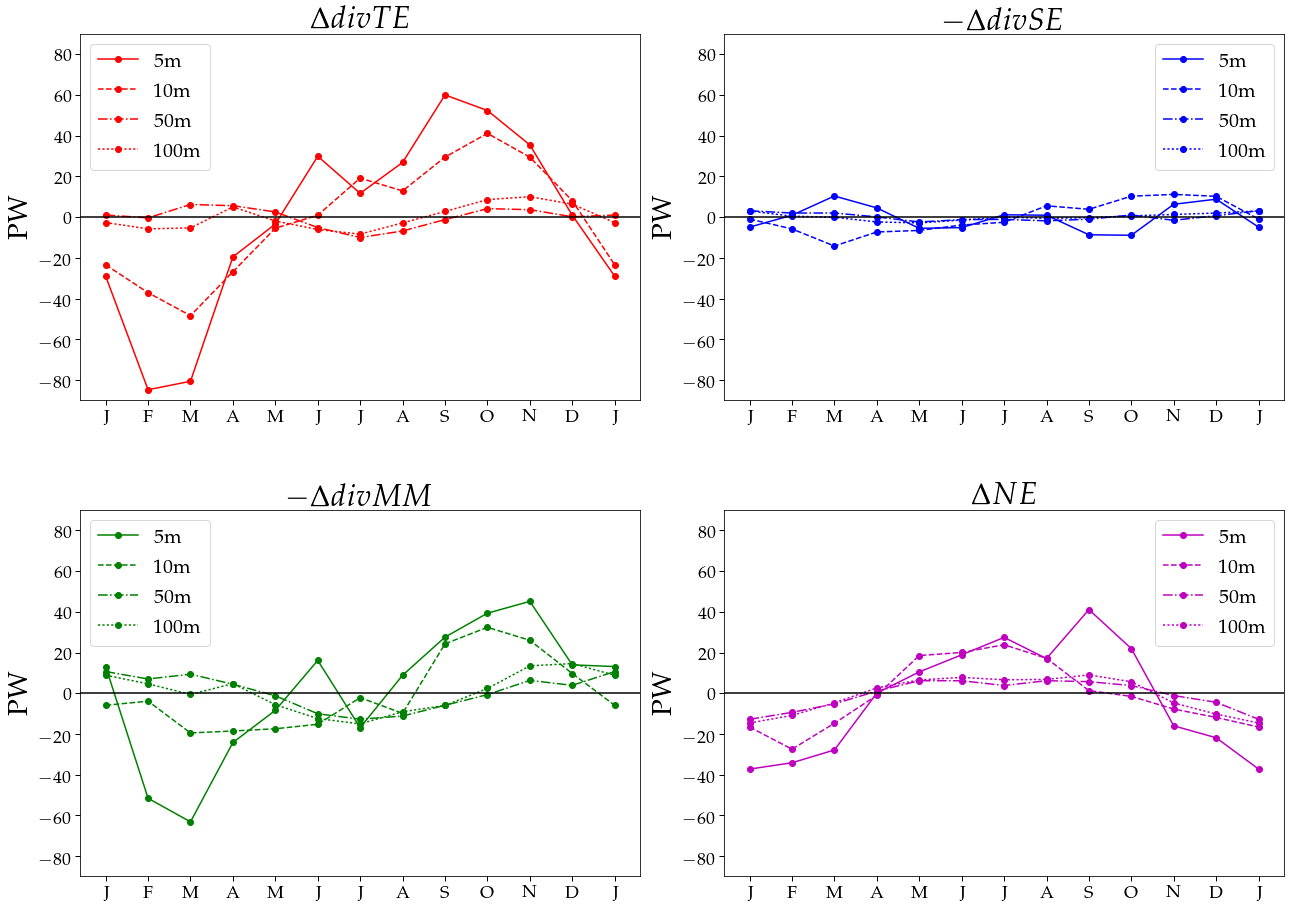

In [567]:
m_to_m=0; l=90
fig=py.figure(figsize=(22, 15))
compare_plot(1,P_div_TE,'r',r'$\Delta {divTE}$',m_to_m,l)
compare_plot(2,-P_div_SE,'b',r'$-\Delta {divSE}$',m_to_m,l)
compare_plot(3,-P_div_MM,'g',r'$-\Delta {divMM}$',m_to_m,l)
compare_plot(4,P_div_NE,'m',r'$\Delta {NE}$',m_to_m,l)

In [568]:
month_to_month=0
threshold_value=+1
SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month)
#if d==0:
#    zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(I, threshold_value, find_zero(TE_change,47,7), find_zero(SE_change,50,8), find_zero(MM_change,37,7), find_zero(NE_change))else :
#zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change,40,5), find_zero(NE_change,35,0))
    
#if ((d==0) & (month_to_month==0)):
zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, threshold_value, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))


In [569]:
def d_by_dt(x):
       x=x[...,:-1]
       dt=1*30*24*3600
       N=1
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for l in range(len(lat_a)):
        for d in range(4):
           div[d,l,:]= np.gradient((x[d,l,:])*(fac),dt)
       div=np.append(div, div[:,:,0,None],axis=-1)
       return div

In [570]:
dT_by_dt=d_by_dt(sfc_temp_a)
SFC_calc=np.copy(dT_by_dt)
depths=np.array([5,10,50,100])
Cp=4200; rho=1000
for d in range(4):
    SFC_calc[d,...]=dT_by_dt[d,...]*Cp*depths[d]*rho
SFC_data= (shflx_a + lhflx_a + LW_sfc_a + SW_sfc_a)

In [571]:
Isfc_data_a=np.zeros((4,len(lat_a[1:-1]),13))
Isfc_calc_a=np.copy(Isfc_data)
def A(X):
    Y=(X-np.average(X, axis=0, weights=np.cos(np.radians(lat_a)))[None,:])
    return Y

def interad(x):
    l=np.deg2rad(lat_a[:,None])
    x=x*np.cos(l)
    int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*(int_x_r[:-1])#int_x[::-1][1:]+/2.0
    return avg_int_r/10**15

for d in range(0,4):
    Isfc_data[d,...]=interad(A(SFC_data[d,...]))
    Isfc_calc[d,...]=interad(A(SFC_calc[d,...]))

In [572]:
def plot_SFC_data(X,d,l,title,la=lat_a):
    
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')

    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    D=depths[d]
    n=l/10.0
    v=np.arange(-1*l,l+n,n)

    py.subplot(220+d+1)
    py.contourf(range(13),la,X[d,...] - X.mean(axis=-1)[d,:,None],v, cmap=BuRd); 
    py.colorbar()
    py.title(str(D)+title,fontsize=30)
    
    py.plot(zero_div_TE[d],'ro-')
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=18,size=5,width=1)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)

# Surface energy budget calculation

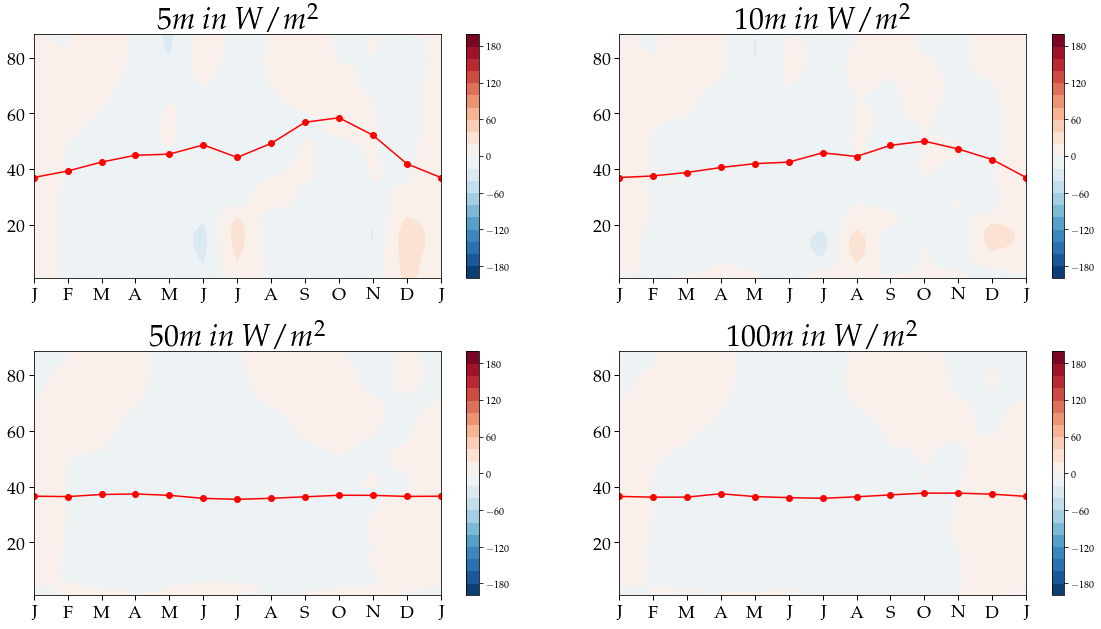

In [573]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(SFC_calc-SFC_data,d,200,r"$m \: in \: W/m^2$")

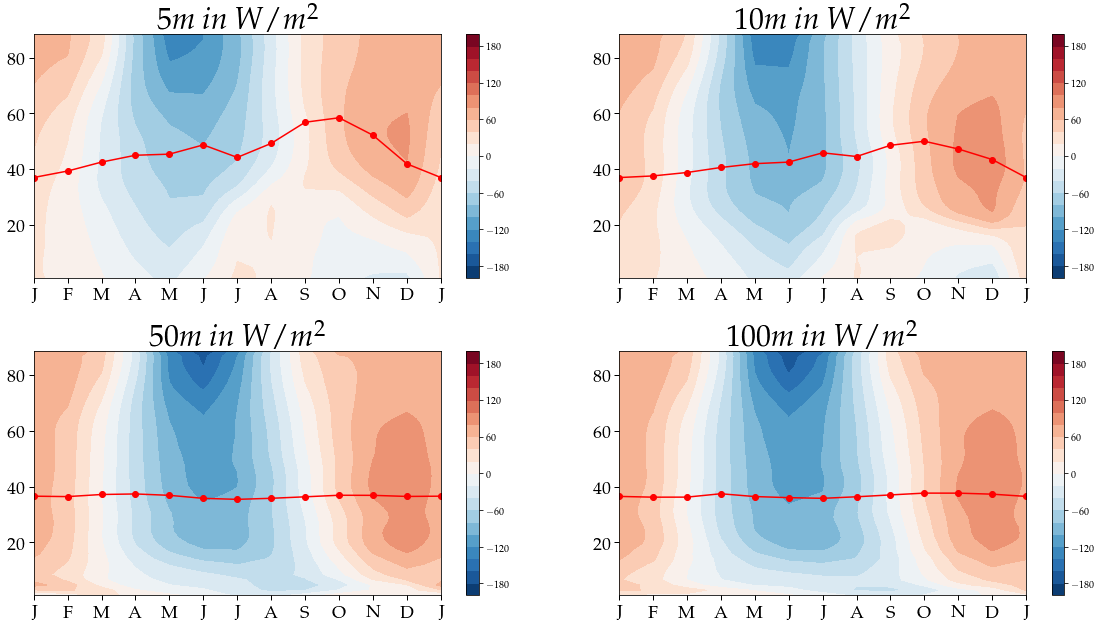

In [574]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(-SFC,d,200,r"$m \: in \: W/m^2$")

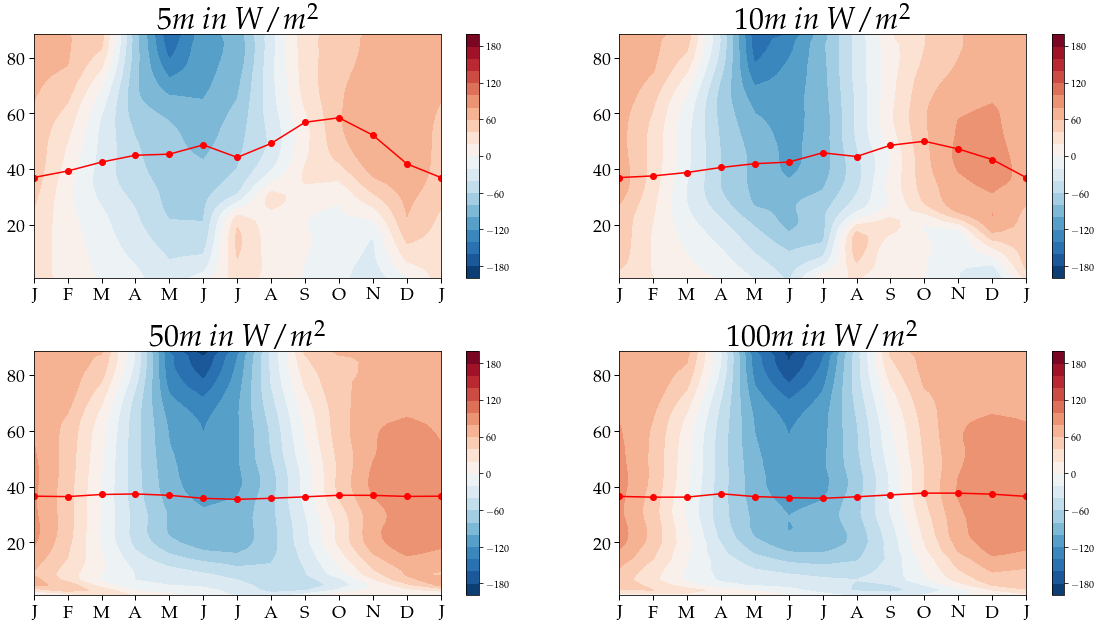

In [575]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(-SFC_data,d,200,r"$m \: in \: W/m^2$")

In [576]:
a=(shflx_a + lhflx_a + LW_sfc_a + SW_sfc_a)

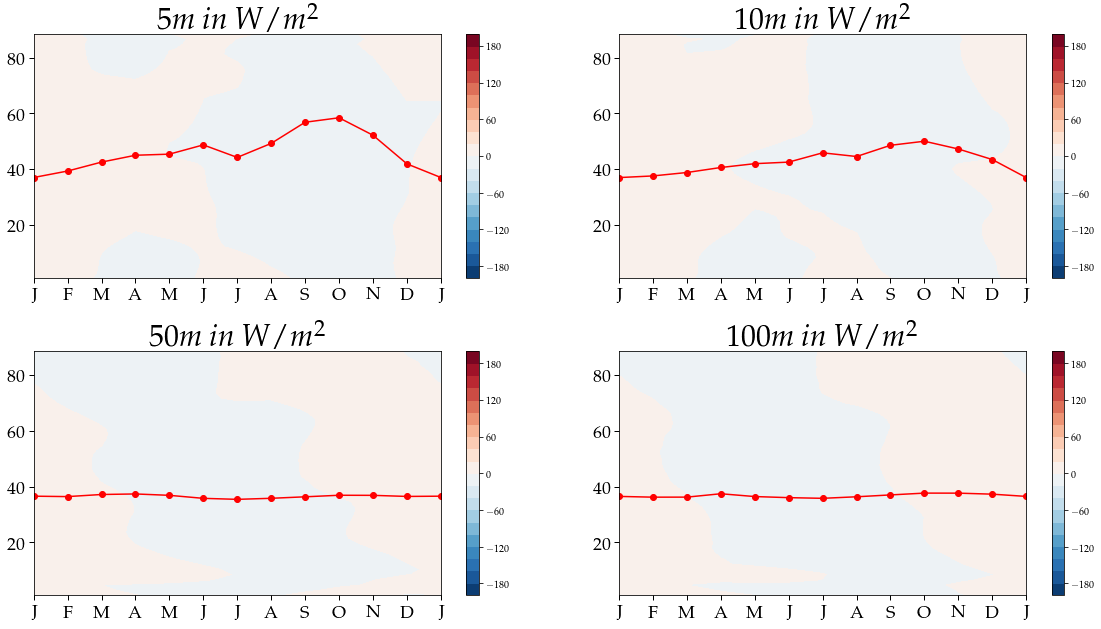

In [577]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(-shflx_a,d,200,r"$m \: in \: W/m^2$")

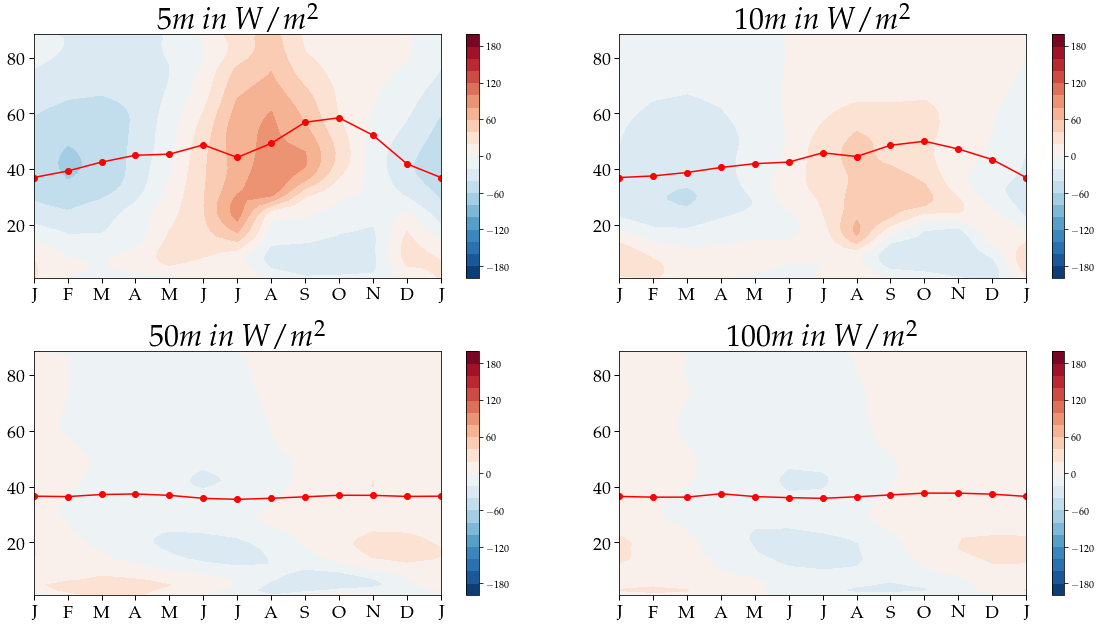

In [578]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(-lhflx_a,d,200,r"$m \: in \: W/m^2$")

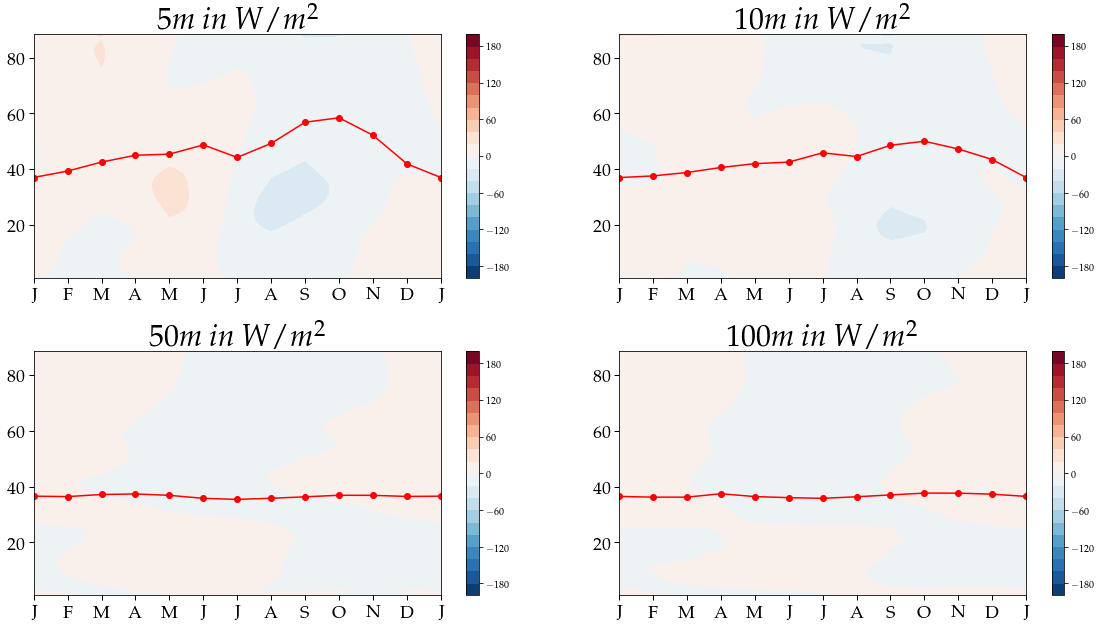

In [579]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(-LW_sfc_a,d,200,r"$m \: in \: W/m^2$")

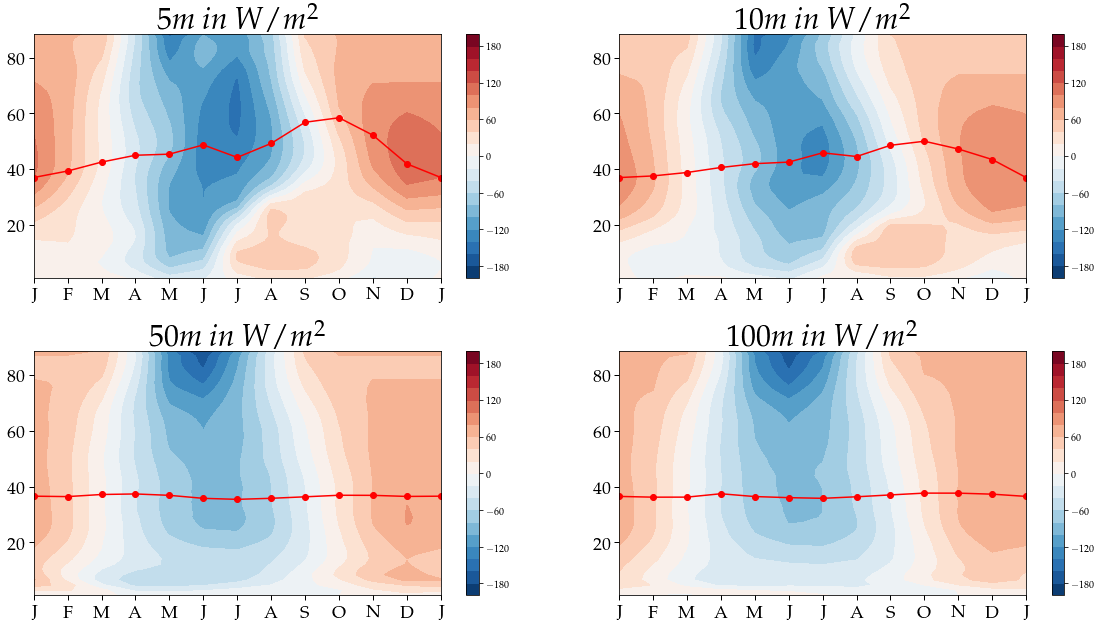

In [580]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(-SW_sfc_a,d,200,r"$m \: in \: W/m^2$")

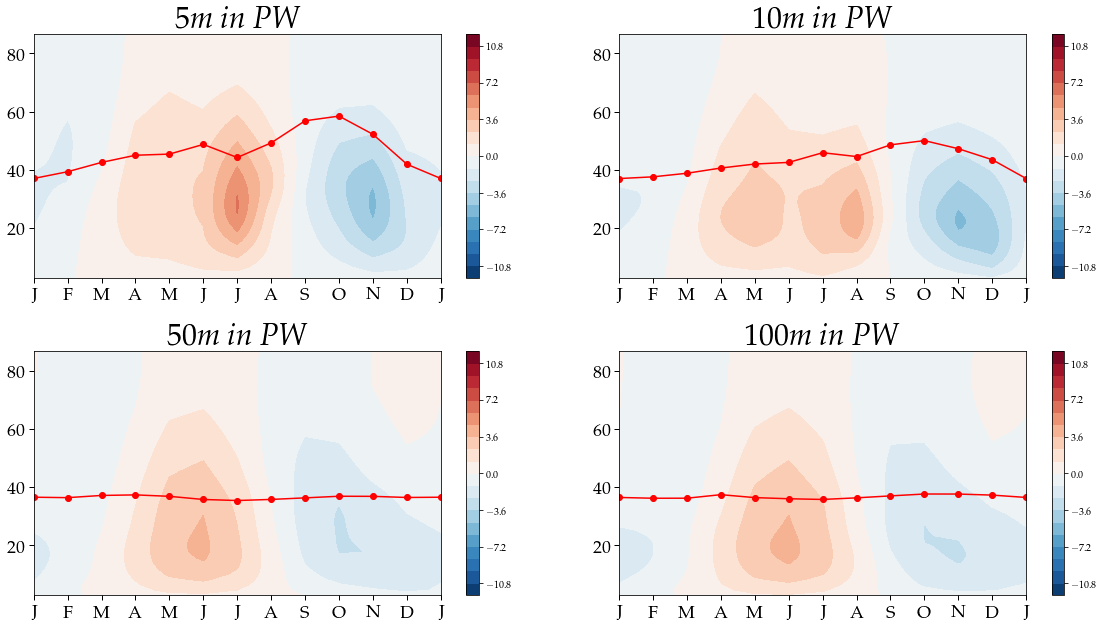

In [581]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(-Isfc_data,d, 12, r"$m \: in \: PW$", lat_a[1:-1])

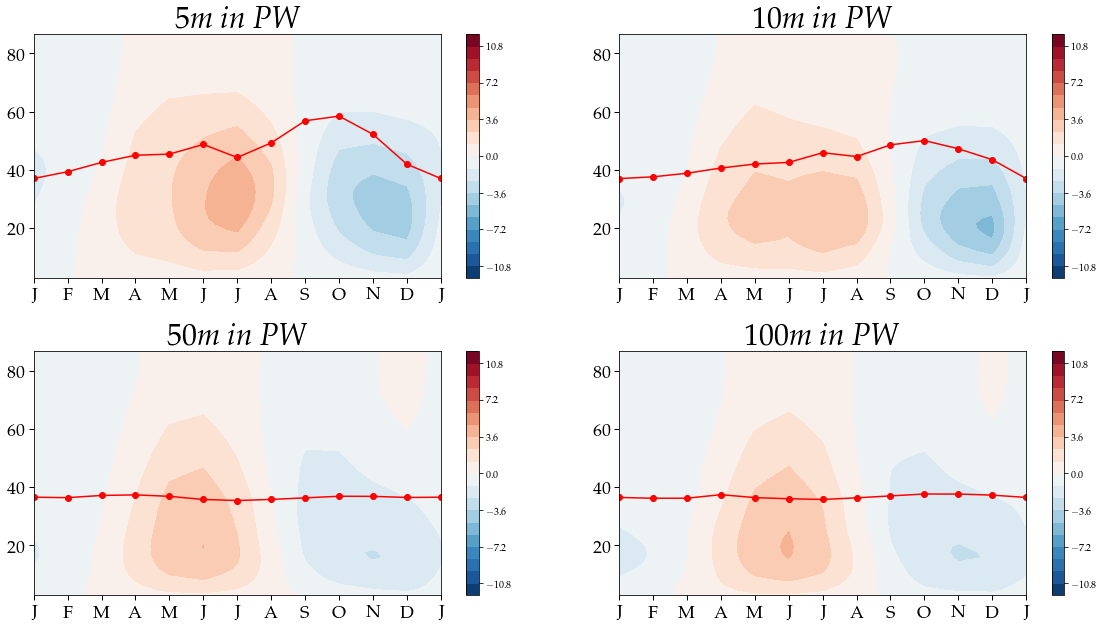

In [582]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(-Isfc_calc,d, 12, r"$m \: in \: PW$", lat_a[1:-1])

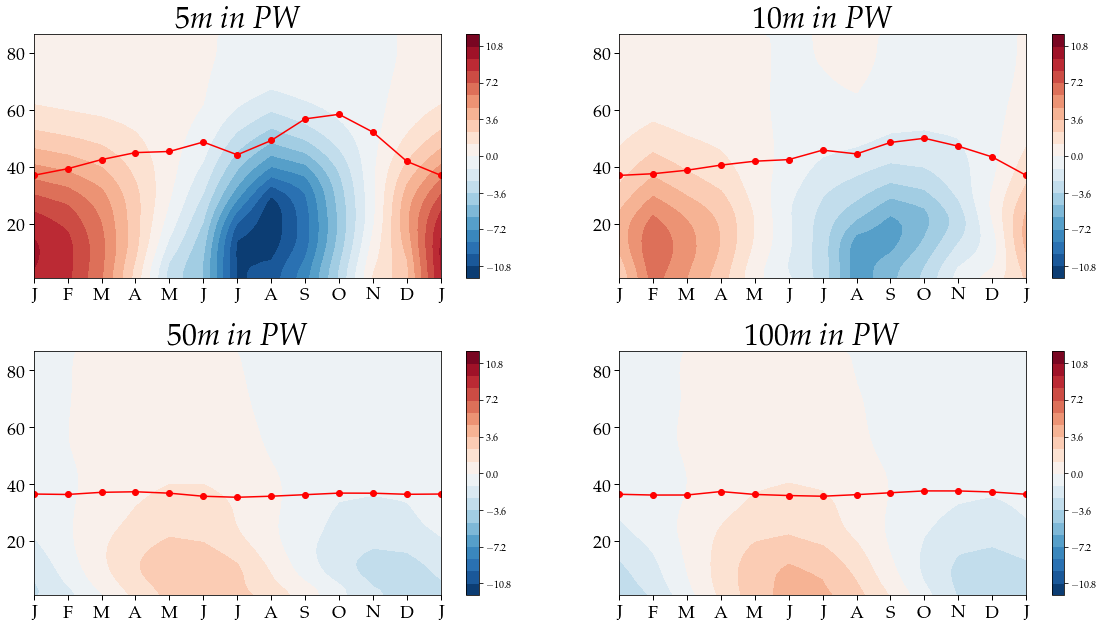

In [583]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(-Ilhflx_a,d, 12, r"$m \: in \: PW$", lat_a[1:])

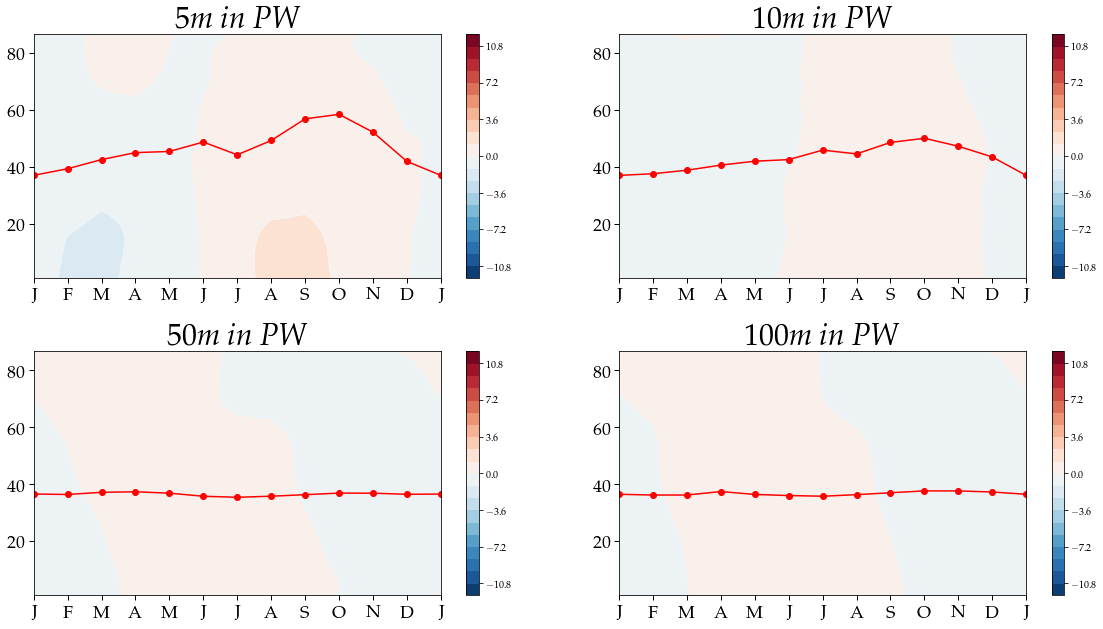

In [584]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(-Ishflx_a,d, 12, r"$m \: in \: PW$", lat_a[1:])

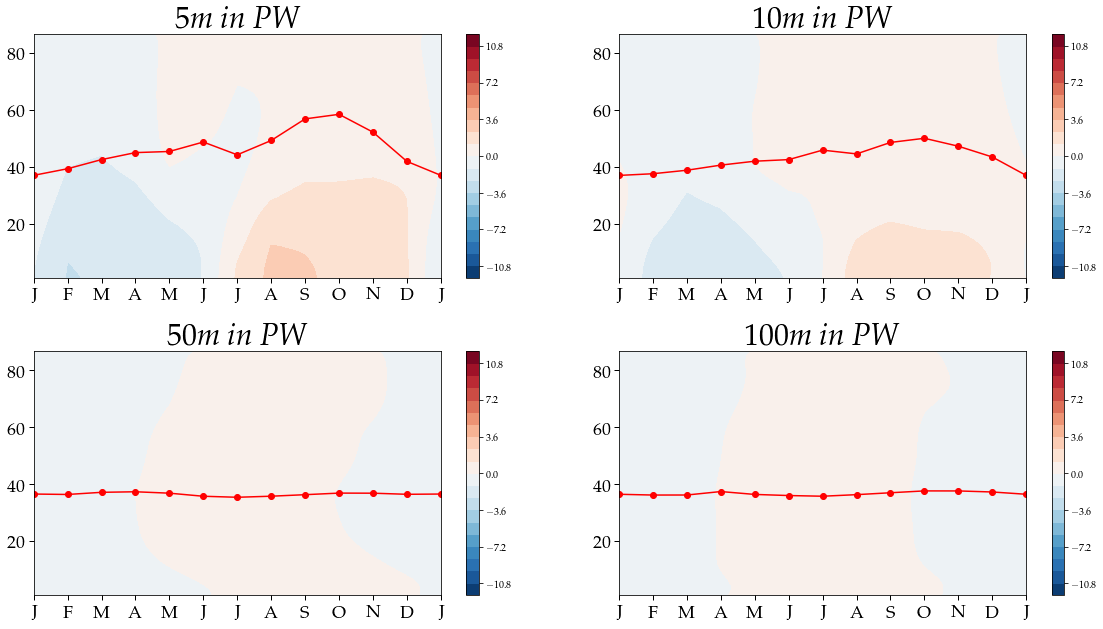

In [585]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(-ILW_sfc_a,d, 12, r"$m \: in \: PW$", lat_a[1:])

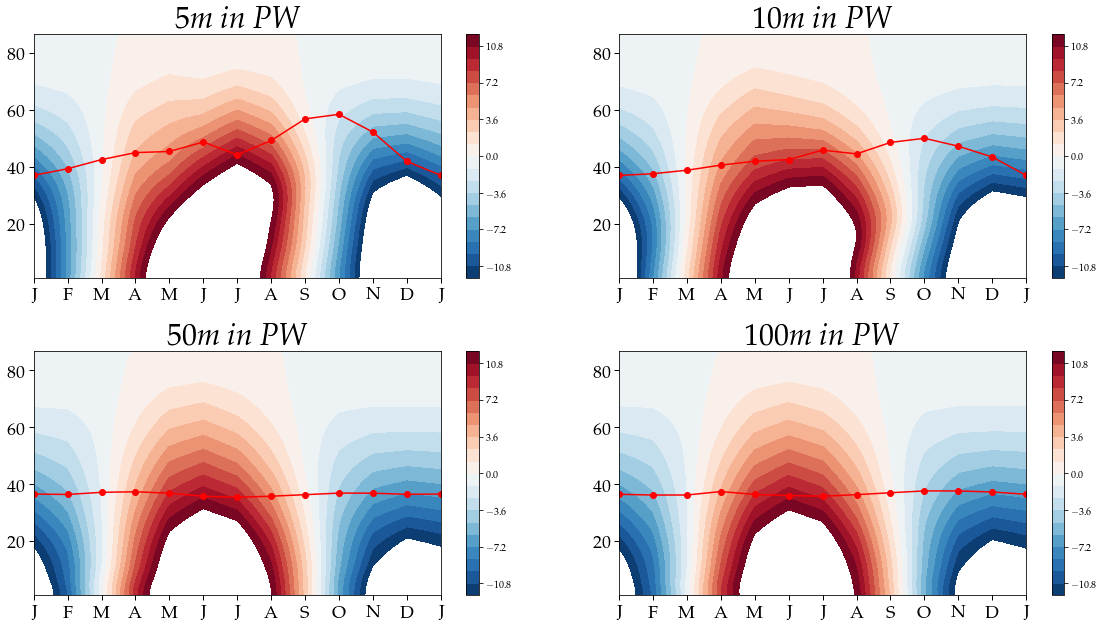

In [586]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(-ISW_sfc_a,d, 12, r"$m \: in \: PW$", lat_a[1:])

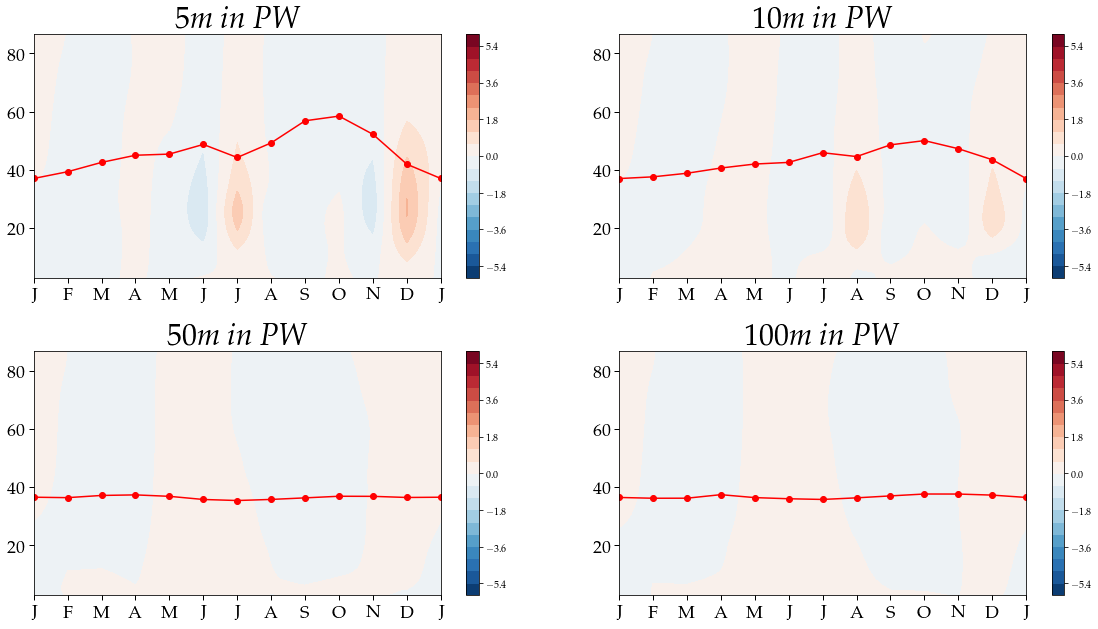

In [587]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(Isfc_calc-Isfc_data,d, 6, r"$m \: in \: PW$", lat_a[1:-1])

In [588]:
P_SFC_data =inerp_at_max(SFC_data,lat_a)
P_SFC_calc =inerp_at_max(SFC,lat_a)

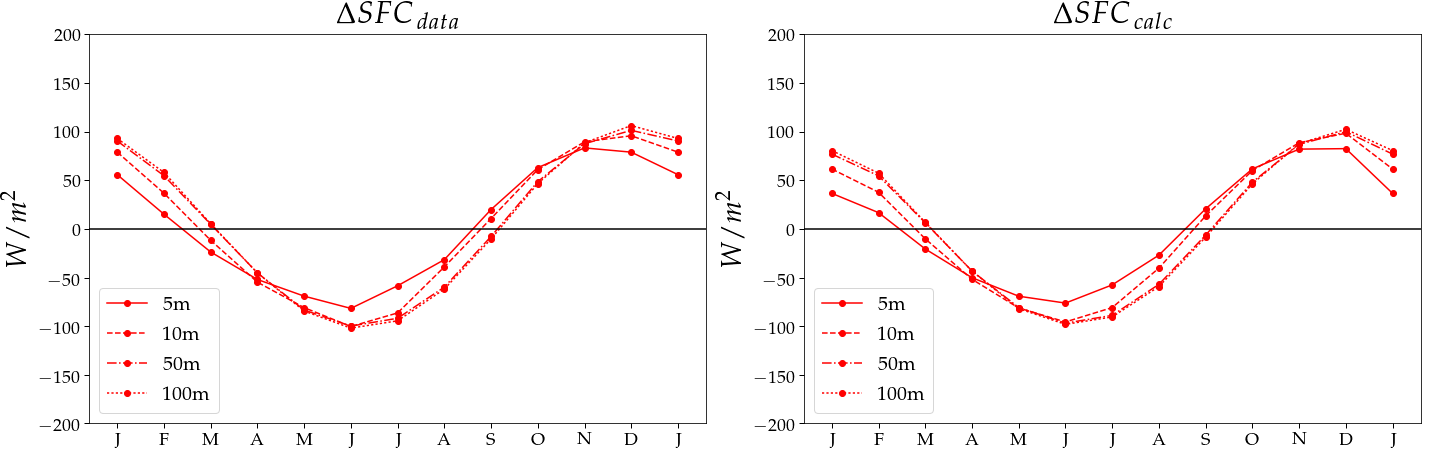

In [589]:
m_to_m=0; l=200
fig=py.figure(figsize=(20, 12))
compare_plot1(1,-P_SFC_data ,'r',r'$\Delta SFC_{\: data}$',m_to_m,l)
compare_plot1(2,-P_SFC_calc ,'r',r'$\Delta SFC_{\: calc}$',m_to_m,l)

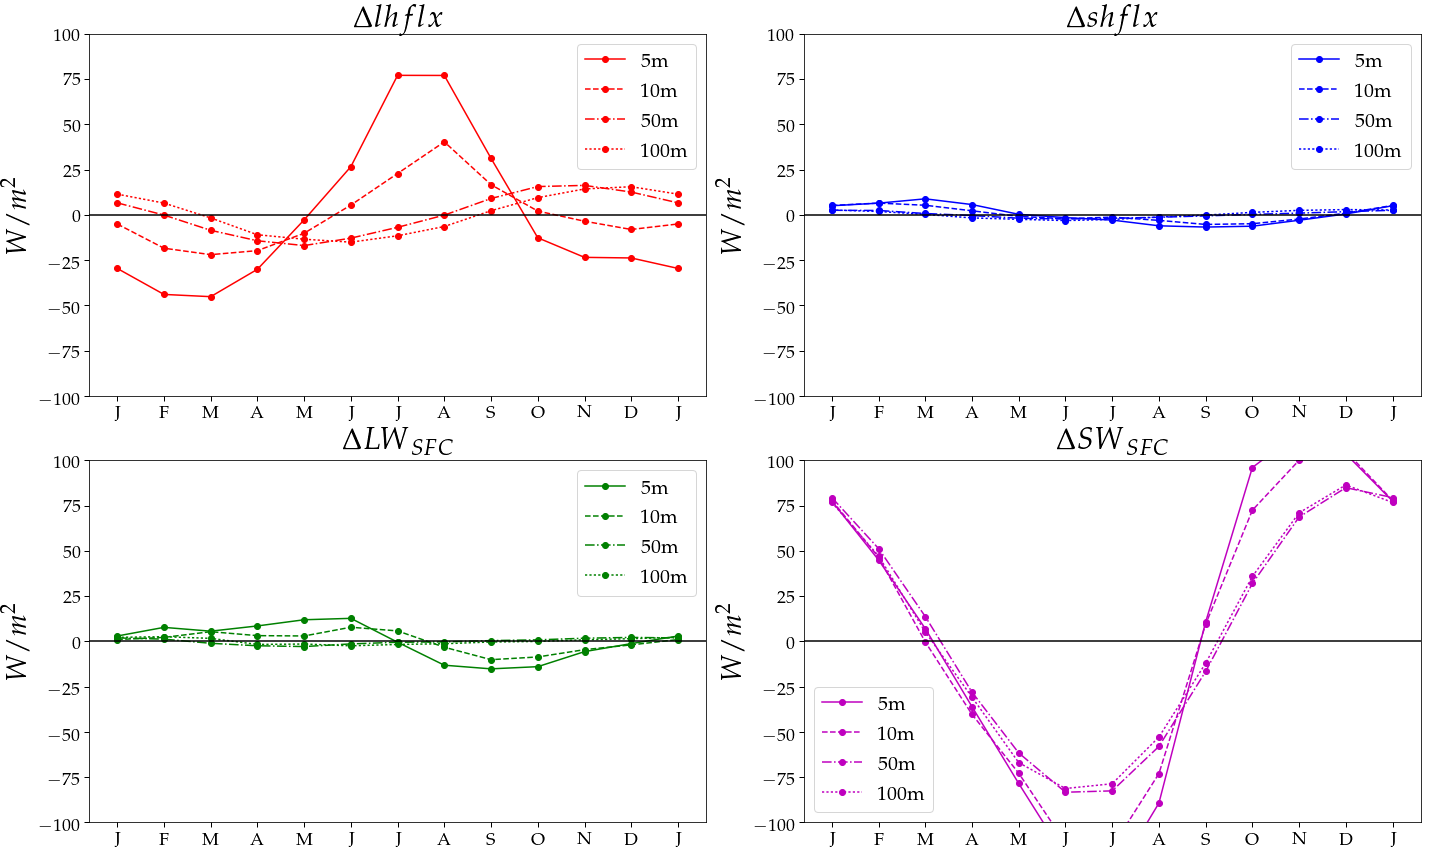

In [620]:
m_to_m=0; l=100
fig=py.figure(figsize=(20, 12))
compare_plot1(1,-P_LHFLX,'r',r' $\Delta {lhflx}$',m_to_m,l)
compare_plot1(2,-P_SHFLX,'b',r' $\Delta {shflx}$',m_to_m,l)
compare_plot1(3,-P_LW_SFC,'g',r'$  \Delta LW_{\:SFC}$',m_to_m,l)
compare_plot1(4,-P_SW_SFC,'m',r'$\Delta SW_{\:SFC}$',m_to_m,l)

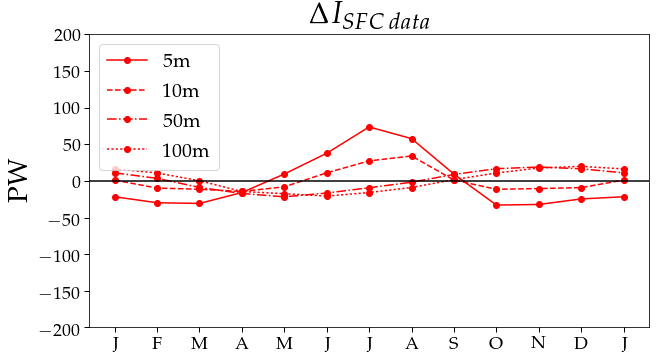

In [614]:
m_to_m=0; l=200
fig=py.figure(figsize=(22, 12))
compare_plot(1,-(P_SFC_data-P_SW_SFC) ,'r',r'$\Delta I_{SFC\:data}',m_to_m,l)

In [591]:
I_SFC_data =inerp_at_max(Isfc_data,lat_a[1:-1])
I_SFC_calc =inerp_at_max(Isfc_calc,lat_a[1:-1])

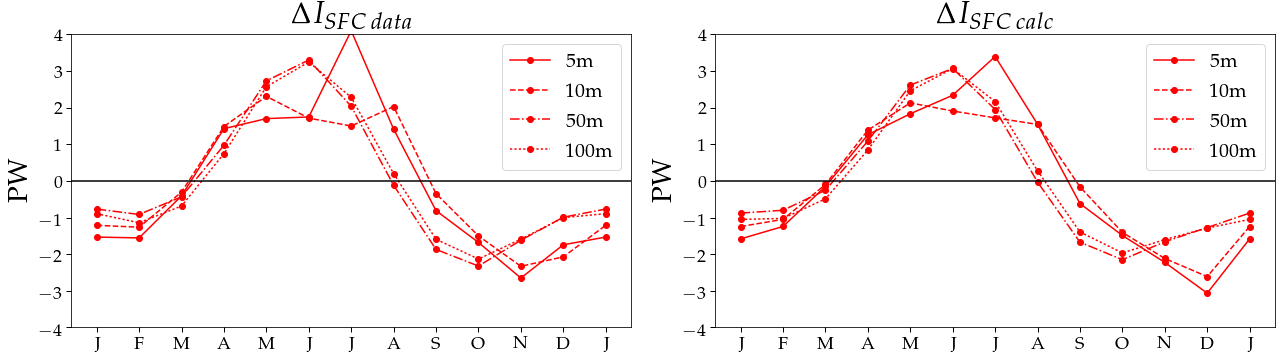

In [617]:
m_to_m=0; l=4
fig=py.figure(figsize=(22, 12))
compare_plot(1,-I_SFC_data ,'r',r'$\Delta I_{SFC\:data}',m_to_m,l)
compare_plot(2,-I_SFC_calc ,'r',r'$\Delta I_{SFC\:calc}$',m_to_m,l)

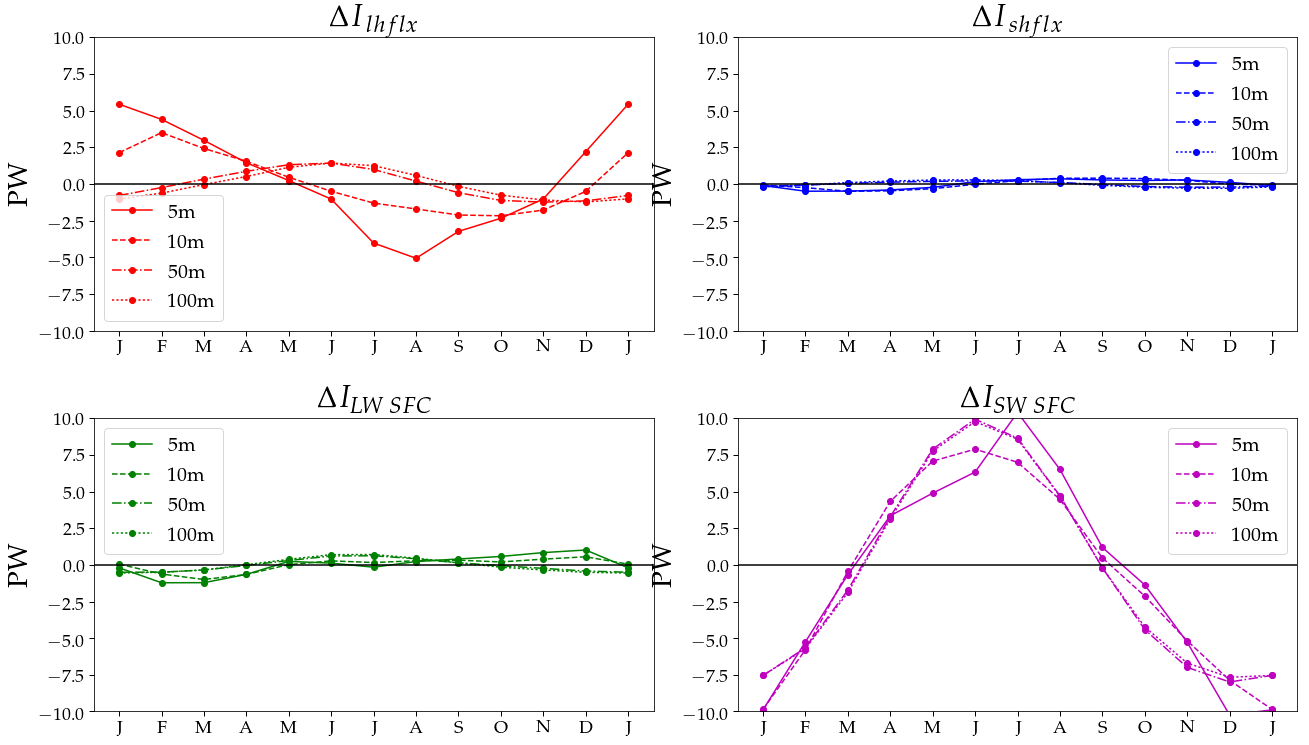

In [621]:
m_to_m=0; l=10
fig=py.figure(figsize=(22, 12))
compare_plot(1,-I_LHFLX,'r',r' $\Delta I_{\:lhflx}$',m_to_m,l)
compare_plot(2,-I_SHFLX,'b',r' $\Delta I_{\:shflx}$',m_to_m,l)
compare_plot(3,-I_LW_SFC,'g',r'$  \Delta I_{LW\:SFC}$',m_to_m,l)
compare_plot(4,-I_SW_SFC,'m',r'$\Delta I_{SW\:SFC}$',m_to_m,l)

In [641]:
def compare_plot_ch(n,X,c,T,month_to_month=1,l=3):
    py.subplot(420+n)
    d=0
    
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    def D(y):
        if month_to_month==1 :
            x1=y[1:]-y[:-1]
            x2=np.append(x1[-1],x1)
        else :
            y1=y[:]-y[:-1,None].mean(axis=0)
            x2=y1
        return x2
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        
    
    py.plot(range(13),D(X[d,:]),c+'o-',label='5m')
    py.plot(range(13),D(X[d+1,:]),c+'o--',label='10m')
    py.plot(range(13),D(X[d+2,:]),c+'o-.',label='50m')
    py.plot(range(13),D(X[d+3,:]),c+'o:',label='100m')
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylabel('PW',fontsize=28)
    py.legend(loc='best',fontsize=20)
    py.axhline(0,color='k')
    py.ylim(-1*l,1*l)
    py.title(T,fontsize=30)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=18,size=5,width=1)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)


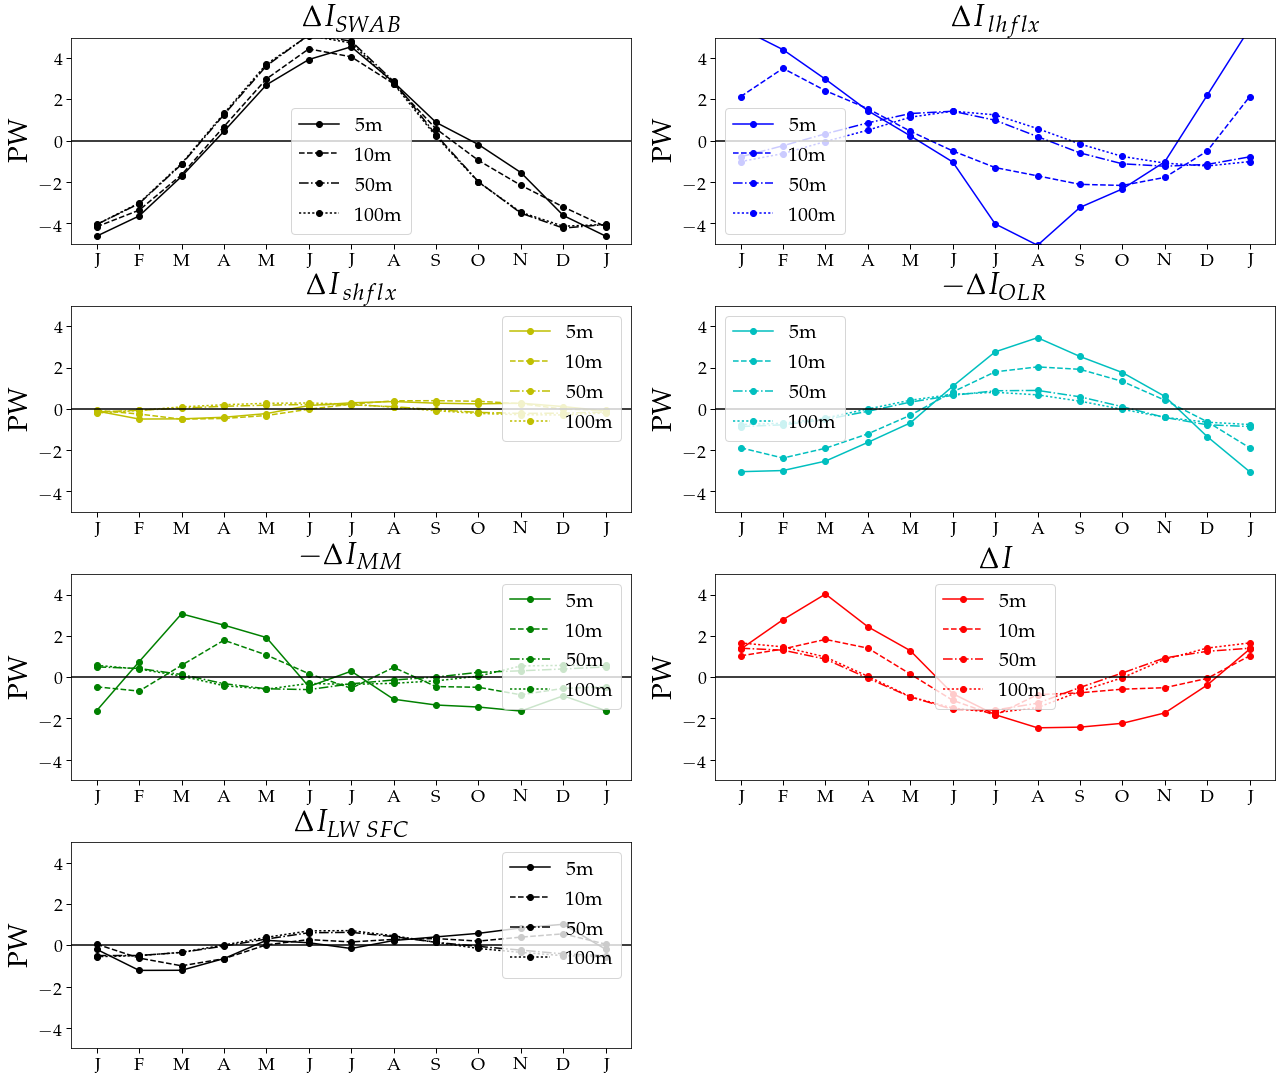

In [642]:
m_to_m=0; l=5
fig=py.figure(figsize=(22, 18))
compare_plot_ch(1,-I_SWAB,'k',r'$  \Delta I_{SWAB}$',m_to_m,l)
compare_plot_ch(2,-I_LHFLX,'b',r' $\Delta I_{\:lhflx}$',m_to_m,l)
compare_plot_ch(3,-I_SHFLX,'y',r' $\Delta I_{\:shflx}$',m_to_m,l)
compare_plot_ch(4,+I_OLR,'c',r'$  - \Delta I_{OLR}$',m_to_m,l)
compare_plot_ch(5,-Intensity_mm,'g',r'$-\Delta I_{MM}$',m_to_m,l)
compare_plot_ch(6,+Intensity_te,'r',r'$\Delta I$',m_to_m,l)
compare_plot_ch(7,-I_LW_SFC,'k',r'$  \Delta I_{LW\:SFC}$',m_to_m,l)

In [654]:
### radiation

def D(y,d):
    y1=np.append(y,y[:,0,np.newaxis],axis=1)
    x1=y1[d,1:]-y1[d,:-1]
    x2=np.append(x1[-1],x1)
    return x2

def plot_delta_NE_ch(d,l,month_to_month=1):
    
    if d==0: depth=5
    if d==1:depth=10
    if d==2:depth=50
    if d==3:depth=100
     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
      
    
    fig=py.figure(figsize=(15, 9))           
    #py.plot(D(I_NE,d),'mo-',label=r'$\Delta I_{NE}$',lw=2.5)
    py.plot(D(I_SWAB,d),'ko-',label=r'$\Delta I_{SWABS}$',lw=2.5)
    py.plot(D(-I_LHFLX,d),'bo-',label=r'$\Delta I_{lhflx}$',lw=2.5)
    py.plot(D(-I_SHFLX,d),'yo-',label=r'$\Delta I_{shflx}$',lw=2.5)
    py.plot(D(I_OLR,d),'co-',label=r'$ - \Delta I_{OLR}$',lw=2.5) 
    py.plot(D(-Intensity_mm,d),'go-',label=r'$ - \Delta I_{MM}$',lw=2.5) 
    py.plot(D(I_dhdt,d),'mo-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
    py.plot(D(Intensity_te,d),'ro-',label=r'$ - \Delta I$',lw=5.5) 
        #py.plot(D(-I_dhdt_S,d),'ko-',label=r'$ - \Delta I_{\frac{dh}{dt}}$',lw=2.5) 
    py.axhline(0, color='k',linewidth=1.5)
    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title="Intensity decomposition"+" "+" ("+str(depth)+"m)"
    title1="Intensity_decomposition_"+"_"+str(depth)+"m"
    py.title(title,fontsize=40,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.axhspan(-0.3, 0.3, facecolor='0.5', alpha=0.3)
    py.legend(fontsize=25,ncol=2,frameon=False, loc='best')
    
    #py.savefig(fig_dest+title1+'.pdf')
    print fig_dest+title1+'.pdf'

    
    py.tight_layout()

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/Intensity_decomposition__5m.pdf


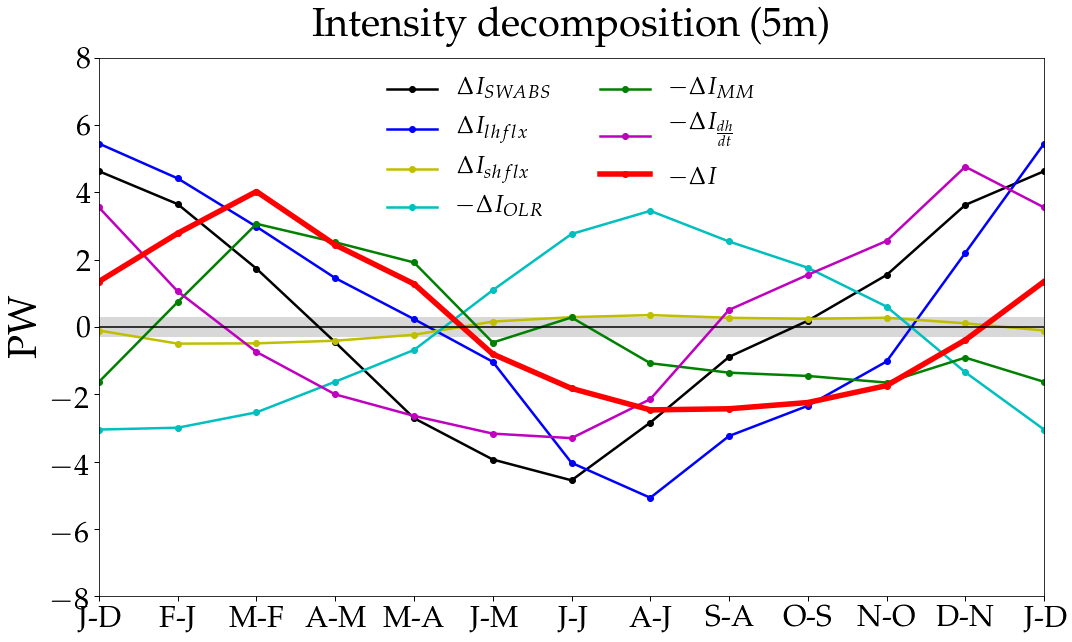

In [655]:
d=0;l=8;
plot_delta_NE_ch(d,l,month_to_month=0)

/project2/tas1/pragallva/Spring_quarter_2018/figures/intensity/Intensity_decomposition__100m.pdf


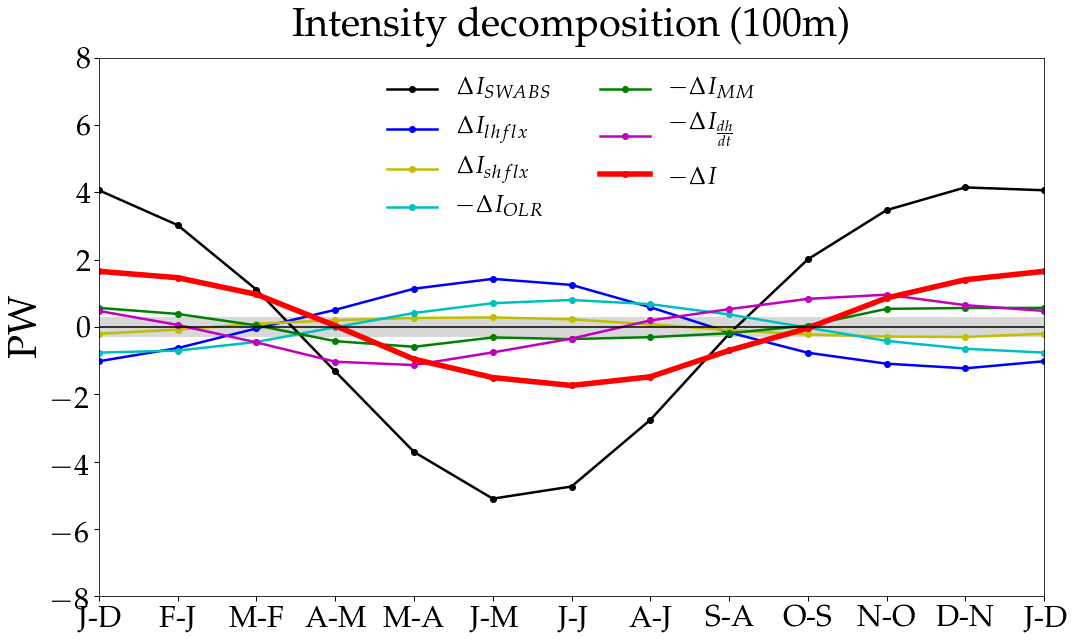

In [656]:
d=3;l=8;
plot_delta_NE_ch(d,l,month_to_month=0)

In [631]:
Intensity_mm.shape

(4, 13)

# TOA calculation

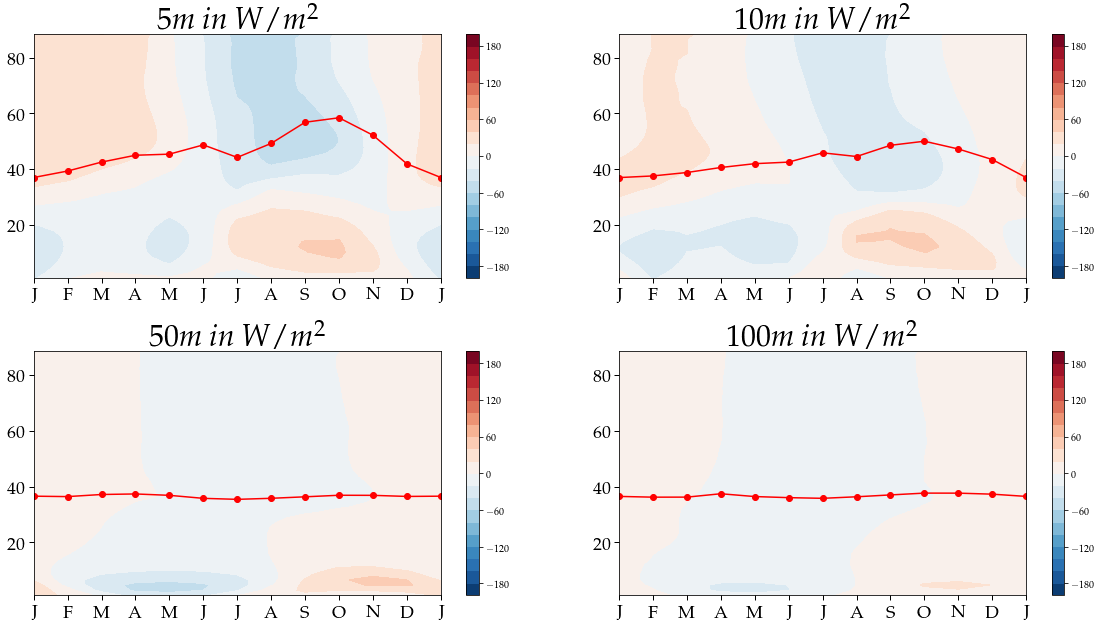

In [594]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(OLR_a,d,200,r"$m \: in \: W/m^2$")

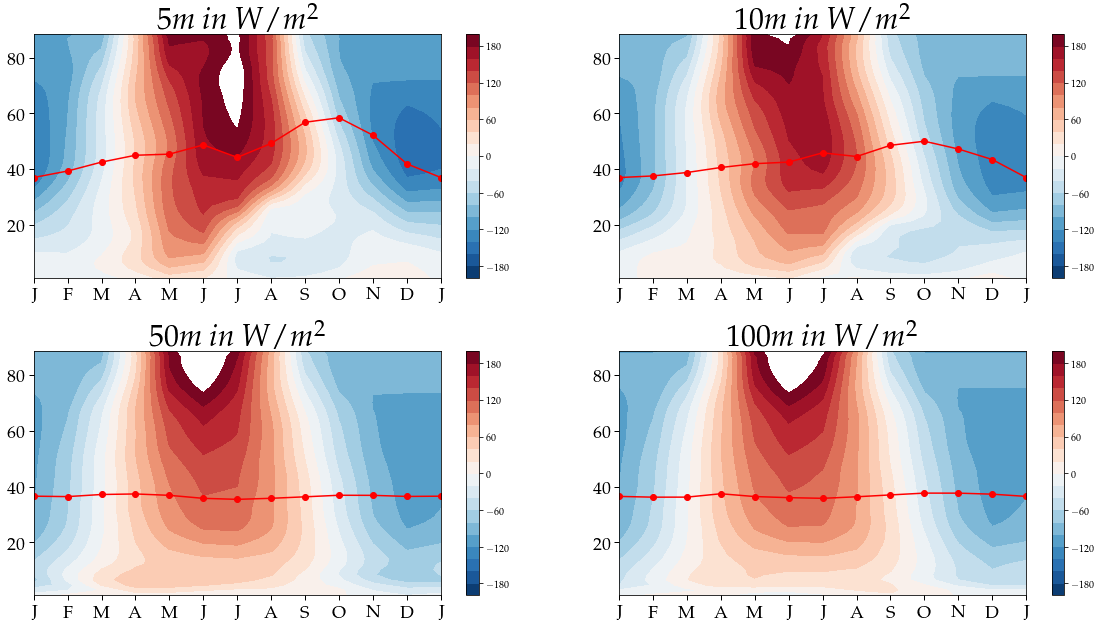

In [595]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(SW_toa_a,d,200,r"$m \: in \: W/m^2$")

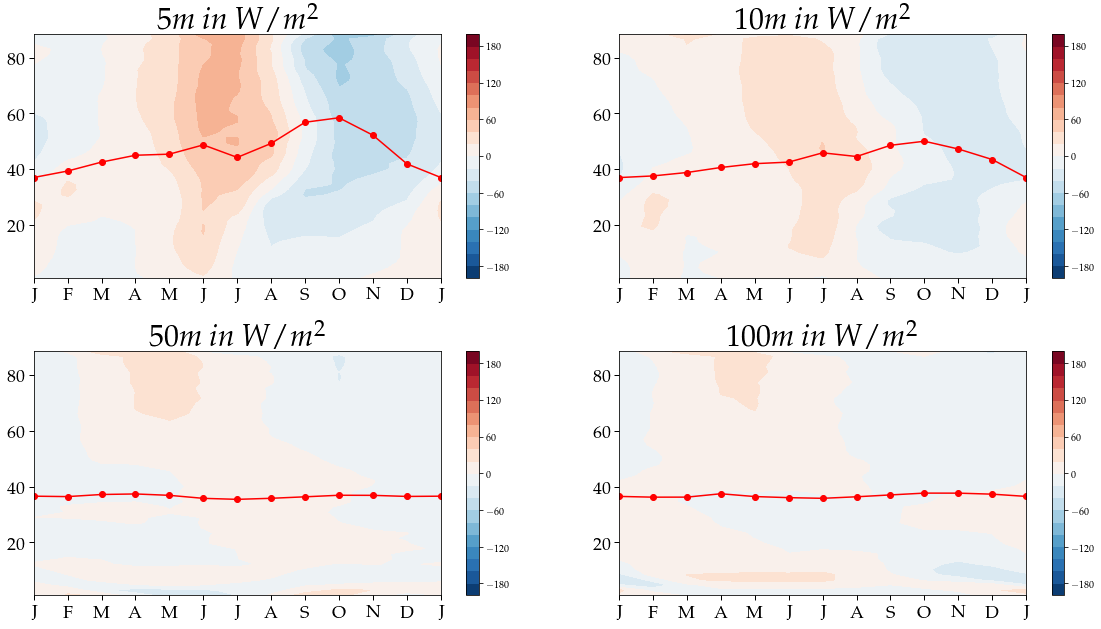

In [596]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(dhdt_a,d,200,r"$m \: in \: W/m^2$")

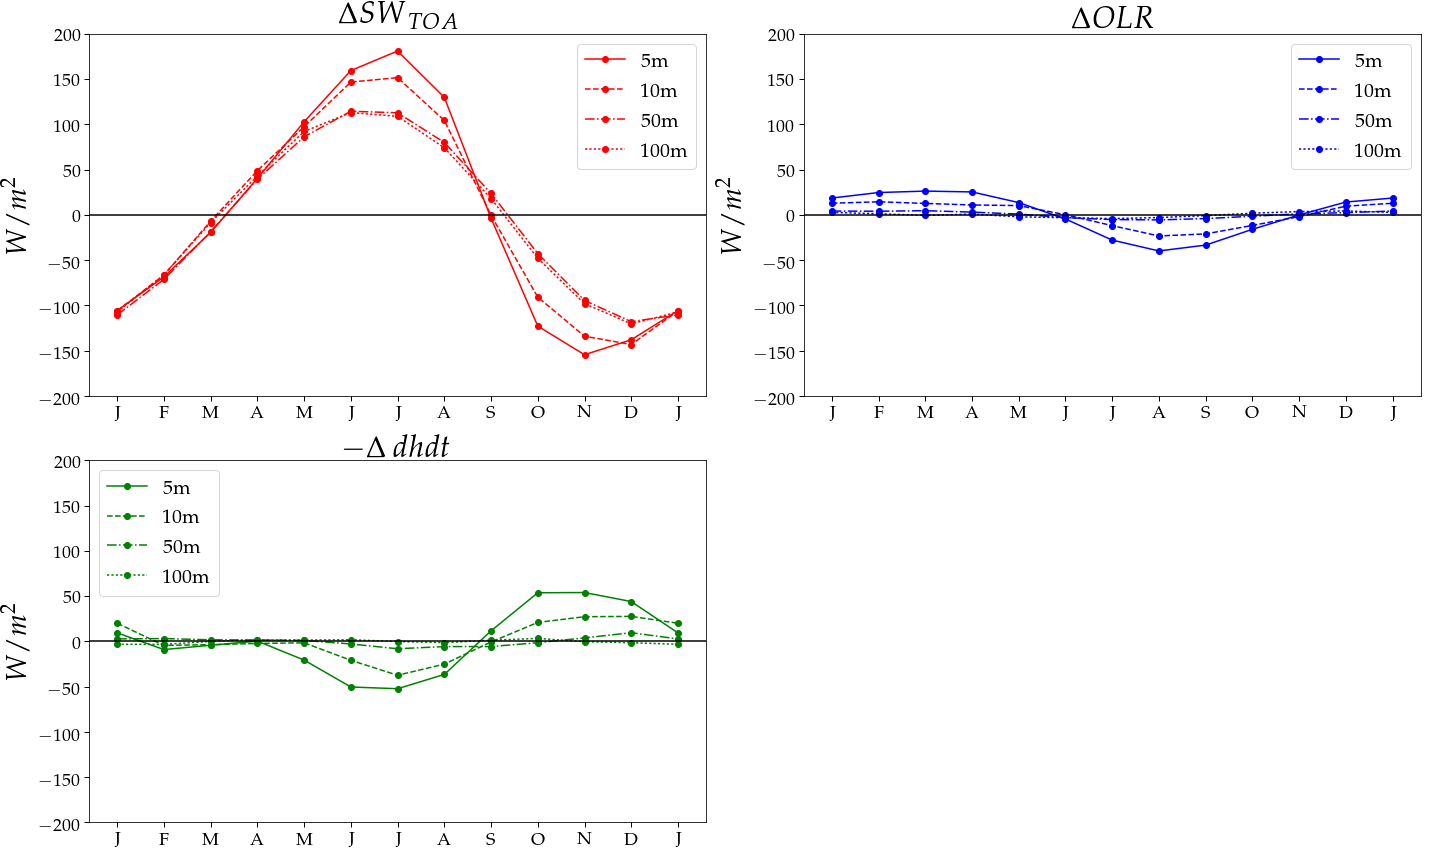

In [597]:
m_to_m=0; l=200
fig=py.figure(figsize=(20, 12))
compare_plot1(1,P_SW_TOA,'r',r' $\Delta SW_{\:TOA}$',m_to_m,l)
compare_plot1(2,P_OLR,'b',r' $\Delta {OLR}$',m_to_m,l)
compare_plot1(3,-P_dhdt,'g',r'$  - \Delta {\:dhdt}$',m_to_m,l)

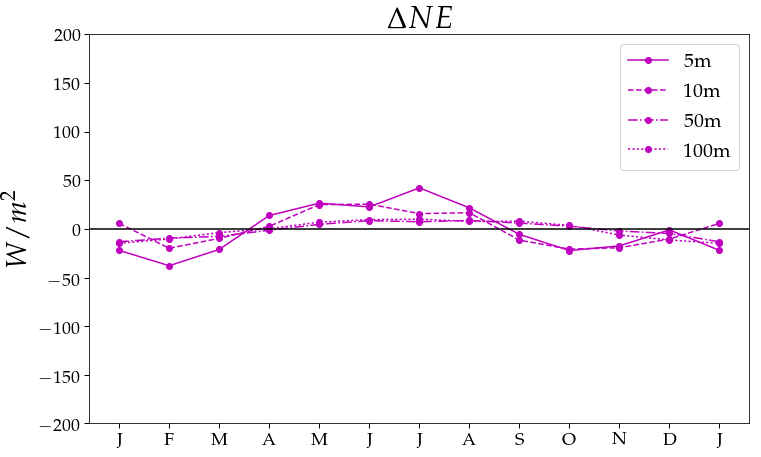

In [605]:
m_to_m=0; l=200
fig=py.figure(figsize=(20, 12))
compare_plot1(2,P_SW_TOA+P_OLR-P_dhdt-P_SFC_data ,'m',r'$\Delta NE$',m_to_m,l)

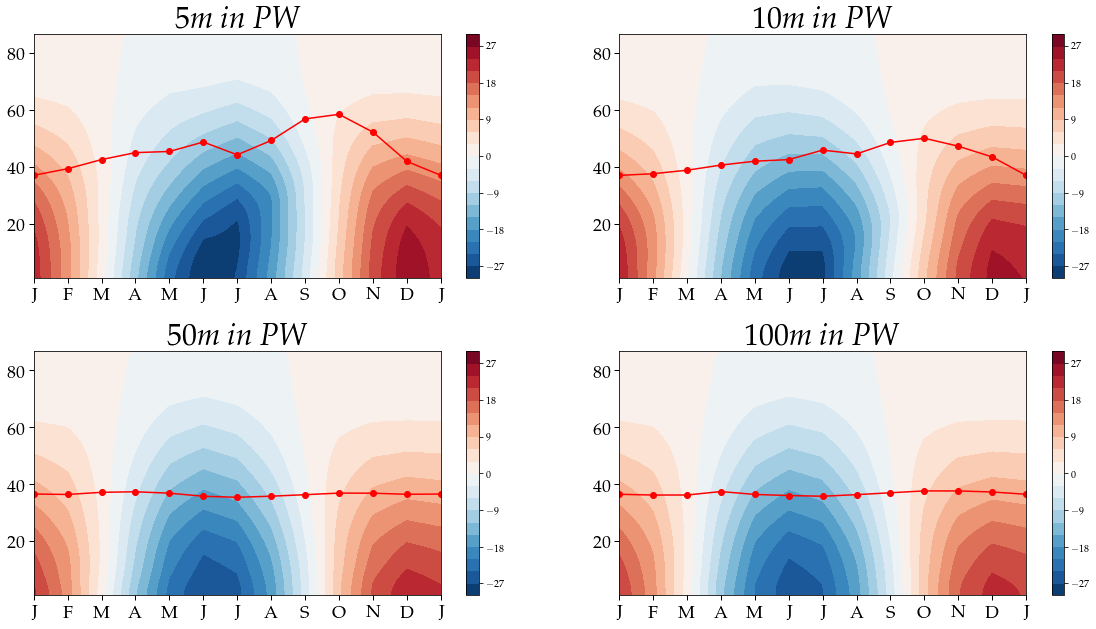

In [598]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(ISW_toa_a,d, 30, r"$m \: in \: PW$", lat_a[1:])

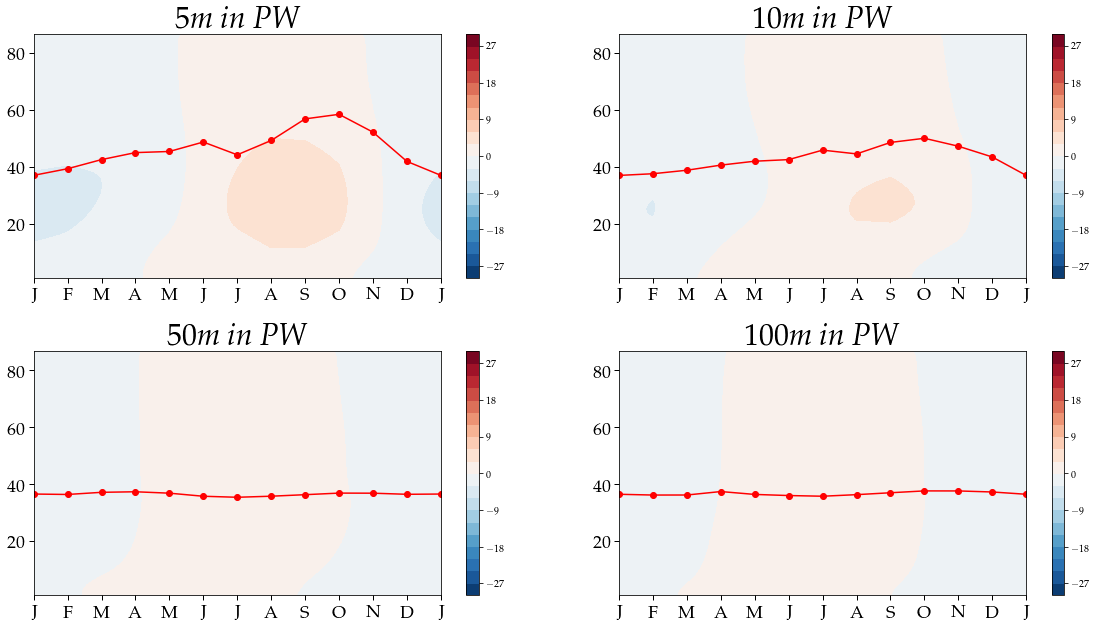

In [599]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(Iolr_a,d, 30, r"$m \: in \: PW$", lat_a[1:])

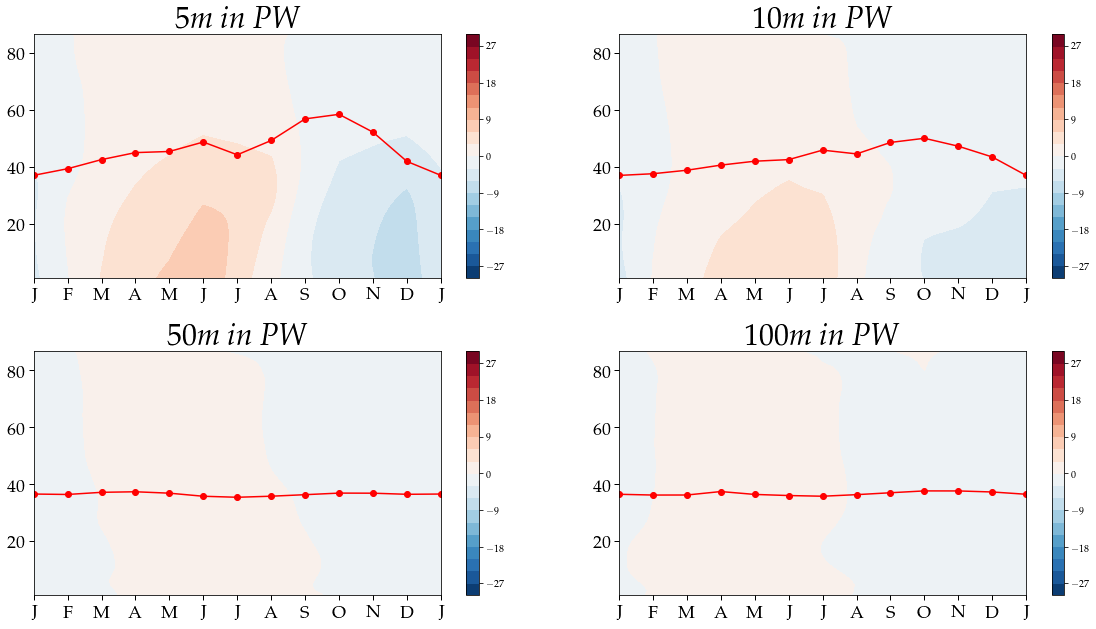

In [600]:
py.figure(figsize=(20,10))
for d in range(4):
    plot_SFC_data(-Idhdt_a,d,30, r"$m \: in \: PW$", lat_a[1:])

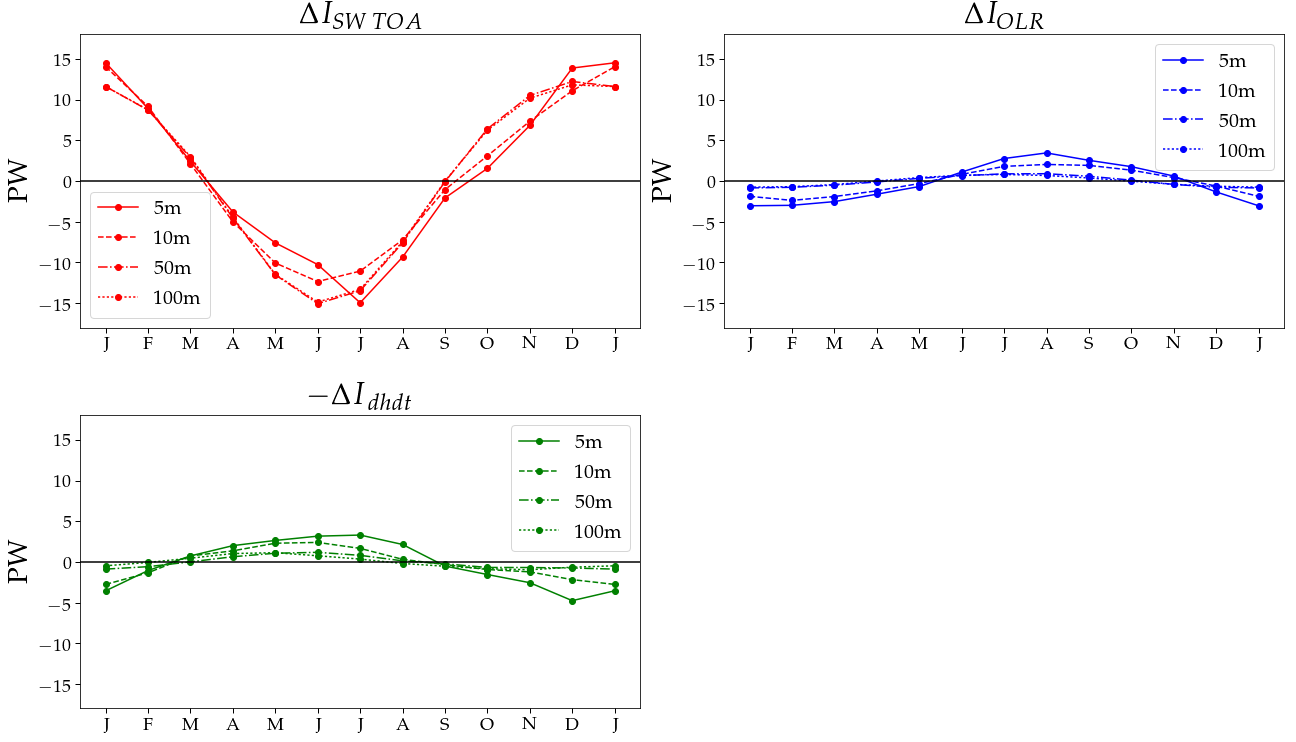

In [601]:
m_to_m=0; l=18
fig=py.figure(figsize=(22, 12))
compare_plot(1,I_SW_TOA,'r',r' $\Delta I_{SW\:TOA}$',m_to_m,l)
compare_plot(2,I_OLR ,'b',r' $\Delta I_{OLR}$',m_to_m,l)
compare_plot(3,-I_dhdt,'g',r'$  -\Delta I_{\:dhdt}$',m_to_m,l)

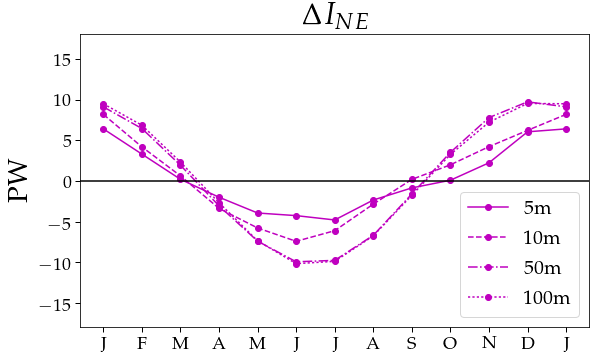

In [611]:
m_to_m=0; l=18
fig=py.figure(figsize=(20, 12))
compare_plot(1,I_SW_TOA+I_OLR-I_dhdt-I_SFC_data ,'m',r'$\Delta I_{NE}$',m_to_m,l)

2


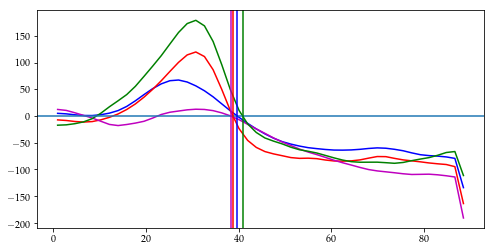

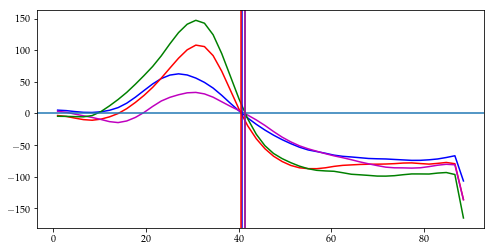

In [95]:
py.figure(1,figsize=(8,4))
m=m+1
d=1
py.plot(lat_a, SE_change[d,:,m],'b-')
py.plot(lat_a,TE_change[d,:,m],'r-')
py.plot(lat_a,NE_change[d,:,m],'m-')
py.plot(lat_a,MM_change[d,:,m],'g-')
py.axhline(0)
py.axvline(zero_div_SE[d,m],color='b')
py.axvline(zero_div_TE[d,m],color='r')
py.axvline(zero_div_MM[d,m],color='g')
py.axvline(zero_div_NE[d,m],color='m')
#py.axvline(base_pos,color='k',linewidth=5)
py.figure(2,figsize=(8,4))
py.plot(lat_a, SE_change[d,:,m+1],'b-')
py.plot(lat_a,TE_change[d,:,m+1],'r-')
py.plot(lat_a,NE_change[d,:,m+1],'m-')
py.plot(lat_a,MM_change[d,:,m+1],'g-')
py.axhline(0)
py.axvline(zero_div_SE[d,m+1],color='b')
py.axvline(zero_div_TE[d,m+1],color='r')
py.axvline(zero_div_MM[d,m+1],color='g')
py.axvline(zero_div_NE[d,m+1],color='m')
#py.axvline(base_pos,color='k',linewidth=5)
print m

# Compare seasonality and intensity

In [74]:
def seasonality(d):
    def M(X):
        l=(X-np.nanmean(X[1:]))/np.nanmax(np.abs(X))
        return l

    fig, ax1 = py.subplots()

    ax1.plot(range(13), M(Intensity_te[d,:]), 'bo-')
    ax1.set_xlabel("Months", color='k',fontsize=20)
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel("Intensity (PW)", color='b',fontsize=20)
    ax1.tick_params(labelsize=18)

    ax2 = ax1.twinx()
    ax2.plot(range(13), M(zero_div_TE[d,:]), 'ro-')
    ax2.set_ylabel("Storm track position (deg)", color='r',fontsize=20)
    ax2.tick_params('y', colors='r')

    fig.tight_layout()
    py.show()

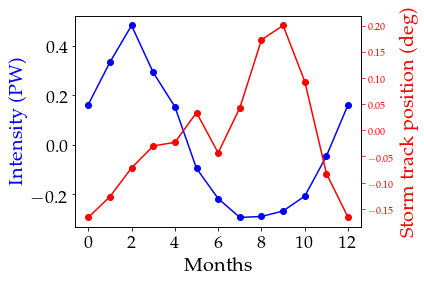

In [86]:
seasonality(0)

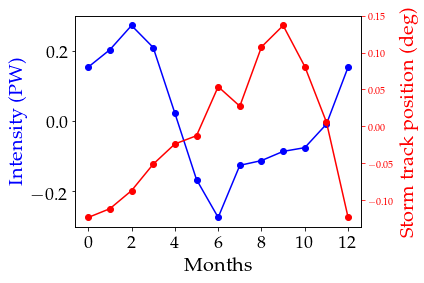

In [87]:
seasonality(1)

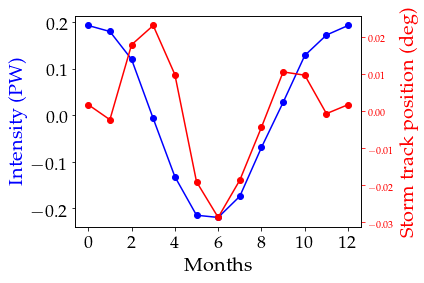

In [88]:
seasonality(2)

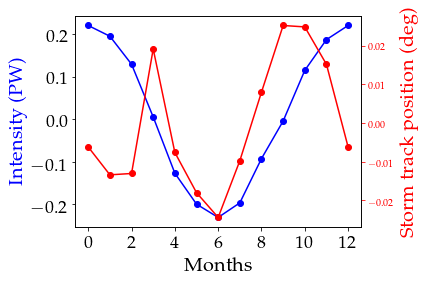

In [89]:
seasonality(3)

In [90]:
def seasonal_value1(X,d):
    delta= np.nanmean(X[d,1:]-X[d,:-1])
    MAX= np.nanmax(np.abs(X[d,:]))
    seas= delta/MAX
    return seas

In [91]:
def seasonal_value2(X,d):
    delta= np.nanmax(np.abs(X[d,:]))-np.nanmin(np.abs(X[d,:]))
    MAX= np.nanmax(np.abs(X[d,:]))
    seas= delta/MAX
    return seas

In [92]:
seas_TE=np.zeros(4); seas_pos=np.copy(seas_TE)
depths=np.array([5,10,50,100])
for d in range(4):
    seas_TE[d]=seasonal_value2(Intensity_te,d)
    seas_pos[d]=seasonal_value2(zero_div_TE,d)

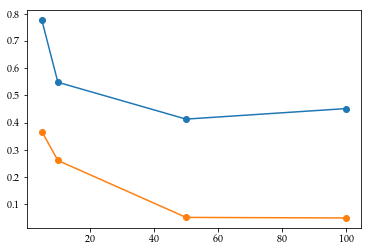

In [93]:
py.plot(depths,seas_TE,'o-')
py.plot(depths,seas_pos,'o-')

In [94]:
print seas_TE
print seas_pos

[ 0.77550026  0.54798445  0.41272416  0.45139388]
[ 0.36691346  0.26088081  0.05183323  0.04969009]


(-13, 13)

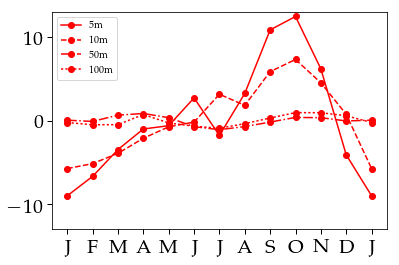

In [95]:
mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
m=0
py.plot(zero_div_TE[m,:]-np.nanmean(zero_div_TE[m,:]),'ro-',label='5m')
m=1
py.plot(zero_div_TE[m,:]-np.nanmean(zero_div_TE[m,:]),'ro--',label='10m')
m=2
py.plot(zero_div_TE[m,:]-np.nanmean(zero_div_TE[m,:]),'ro-.',label='50m')
m=3
py.plot(zero_div_TE[m,:]-np.nanmean(zero_div_TE[m,:]),'ro:', label='100m')
py.xticks(range(13),mticks,size=20)
py.tick_params(labelsize=20,size=5,width=1)
py.legend(loc='best')
py.ylim(-13,13)